In [1]:
cd ..

E:\18-09-19 Document structure\business\Study\Master\Cognitive Computing\P3\Machine learning in practice\git\Private\M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.


Bad key "text.kerning_factor" on line 4 in
E:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.429084,0.500587,0.628482,0.662077,0.743227,0.824528,0.861499,0.989619,1.086067
2011-01-30,0.834881,1.032595,1.265410,1.343565,1.503276,1.660740,1.728179,2.014386,2.143587
2011-01-31,0.838167,0.991256,1.246369,1.329488,1.508577,1.680692,1.763780,1.976137,2.167394
2011-02-01,0.424697,0.501162,0.629065,0.668797,0.758173,0.842714,0.878296,1.015888,1.090475
2011-02-02,0.438830,0.511583,0.630601,0.669403,0.754088,0.842727,0.883785,1.007879,1.084537


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_val, y_val))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 1s 2ms/sample - loss: 0.8993 - val_loss: 0.7962
Epoch 2/300
269/269 [==============================] - 0s 97us/sample - loss: 0.8587 - val_loss: 0.7878
Epoch 3/300
269/269 [==============================] - 0s 95us/sample - loss: 0.8322 - val_loss: 0.7669
Epoch 4/300
269/269 [==============================] - 0s 96us/sample - loss: 0.8060 - val_loss: 0.7432
Epoch 5/300
269/269 [==============================] - 0s 97us/sample - loss: 0.7818 - val_loss: 0.7162
Epoch 6/300
269/269 [==============================] - 0s 100us/sample - loss: 0.7551 - val_loss: 0.6846
Epoch 7/300
269/269 [==============================] - 0s 100us/sample - loss: 0.7278 - val_loss: 0.6598
Epoch 8/300
269/269 [==============================] - 0s 104us/sample - loss: 0.7025 - val_loss: 0.6396
Epoch 9/300
269/269 [==============================] - 0s 104us/sample - loss: 0.6858 - val_loss: 0.6356
Epoch 10/300
269

269/269 [==============================] - 0s 100us/sample - loss: 0.0412 - val_loss: 0.0343
Epoch 79/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0431 - val_loss: 0.0339
Epoch 80/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0501 - val_loss: 0.0473
Epoch 81/300
269/269 [==============================] - 0s 97us/sample - loss: 0.0427 - val_loss: 0.0359
Epoch 82/300
269/269 [==============================] - 0s 106us/sample - loss: 0.0406 - val_loss: 0.0314
Epoch 83/300
269/269 [==============================] - 0s 96us/sample - loss: 0.0366 - val_loss: 0.0316
Epoch 84/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0360 - val_loss: 0.0298
Epoch 85/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0335 - val_loss: 0.0290
Epoch 86/300
269/269 [==============================] - 0s 96us/sample - loss: 0.0355 - val_loss: 0.0357
Epoch 87/300
269/269 [==============================] - 0s 98u

269/269 [==============================] - 0s 98us/sample - loss: 0.0190 - val_loss: 0.0182
Epoch 156/300
269/269 [==============================] - 0s 99us/sample - loss: 0.0176 - val_loss: 0.0185
Epoch 157/300
269/269 [==============================] - 0s 96us/sample - loss: 0.0236 - val_loss: 0.0312
Epoch 158/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0265 - val_loss: 0.0245
Epoch 159/300
269/269 [==============================] - 0s 99us/sample - loss: 0.0211 - val_loss: 0.0192
Epoch 160/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0235 - val_loss: 0.0214
Epoch 161/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0208 - val_loss: 0.0150
Epoch 162/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0143 - val_loss: 0.0116
Epoch 163/300
269/269 [==============================] - 0s 106us/sample - loss: 0.0136 - val_loss: 0.0167
Epoch 164/300
269/269 [==============================] 

269/269 [==============================] - 0s 101us/sample - loss: 0.0151 - val_loss: 0.0199
Epoch 233/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0168 - val_loss: 0.0200
Epoch 234/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0191 - val_loss: 0.0228
Epoch 235/300
269/269 [==============================] - 0s 97us/sample - loss: 0.0159 - val_loss: 0.0232
Epoch 236/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0174 - val_loss: 0.0140
Epoch 237/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0137 - val_loss: 0.0137
Epoch 238/300
269/269 [==============================] - 0s 95us/sample - loss: 0.0187 - val_loss: 0.0152
Epoch 239/300
269/269 [==============================] - 0s 95us/sample - loss: 0.0133 - val_loss: 0.0110
Epoch 240/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0116 - val_loss: 0.0118
Epoch 241/300
269/269 [==============================]

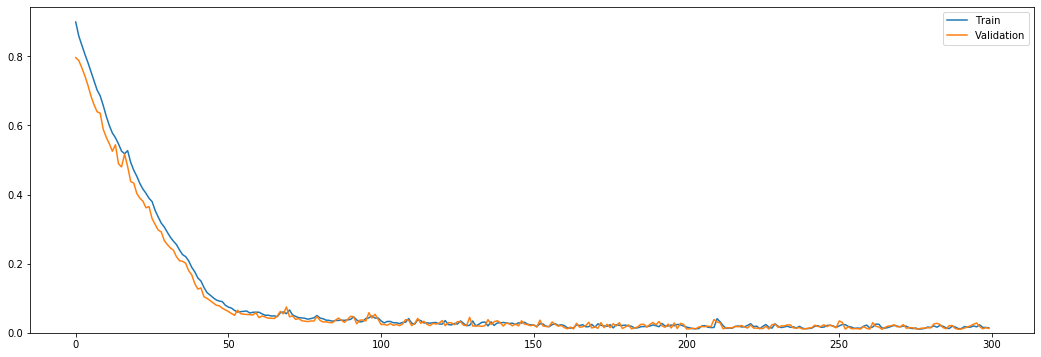

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.41966015, 0.48449773, 0.61979175, 0.6591864 , 0.7422898 ,
        0.8357953 , 0.87168634, 1.0059276 , 1.0771178 ],
       [0.8545235 , 0.9959167 , 1.2444633 , 1.3228614 , 1.4870306 ,
        1.6611773 , 1.7325397 , 1.9857268 , 2.1234481 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [14]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    #out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q2 = Dense(1, name="q2")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q3 = Dense(1, name="q3")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q4 = Dense(1, name="q4")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q5 = Dense(1, name="q5")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q6 = Dense(1, name="q6")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q7 = Dense(1, name="q7")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q8 = Dense(1, name="q8")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    
#     out_q0 = DistributionLayer(quantiles[0],x)
#     out_q1 = DistributionLayer(quantiles[1],x)
#     out_q2 = DistributionLayer(quantiles[2],x)
#     out_q3 = DistributionLayer(quantiles[3],x)
#     out_q4 = DistributionLayer(quantiles[4],x)
#     out_q5 = DistributionLayer(quantiles[5],x)
#     out_q6 = DistributionLayer(quantiles[6],x)
#     out_q7 = DistributionLayer(quantiles[7],x)
#     out_q8 = DistributionLayer(quantiles[8],x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [15]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [16]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [17]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 2s 8ms/sample - loss: 11.3324 - q0_loss: 1.2813 - q1_loss: 0.7030 - q2_loss: 1.3851 - q3_loss: 1.0995 - q4_loss: 1.1211 - q5_loss: 1.3409 - q6_loss: 1.3201 - q7_loss: 1.5380 - q8_loss: 1.5484 - val_loss: 9.4594 - val_q0_loss: 0.7703 - val_q1_loss: 0.4729 - val_q2_loss: 0.7663 - val_q3_loss: 1.5679 - val_q4_loss: 1.3739 - val_q5_loss: 0.4928 - val_q6_loss: 0.9014 - val_q7_loss: 0.7256 - val_q8_loss: 2.1432
Epoch 2/300
269/269 [==============================] - 0s 167us/sample - loss: 8.8200 - q0_loss: 0.5533 - q1_loss: 0.5353 - q2_loss: 0.6168 - q3_loss: 1.0981 - q4_loss: 1.2282 - q5_loss: 0.9953 - q6_loss: 1.2545 - q7_loss: 0.9673 - q8_loss: 1.6328 - val_loss: 7.9687 - val_q0_loss: 0.5776 - val_q1_loss: 0.4084 - val_q2_loss: 0.5365 - val_q3_loss: 0.5103 - val_q4_loss: 0.8611 - val_q5_loss: 1.2860 - val_q6_loss: 1.2469 - val_q7_loss: 1.2070 - val_q8_loss: 0.9169
Epoch 3/300
269/269 [=====

269/269 [==============================] - 0s 171us/sample - loss: 5.9592 - q0_loss: 0.1576 - q1_loss: 0.1446 - q2_loss: 0.1550 - q3_loss: 0.8340 - q4_loss: 1.0610 - q5_loss: 0.6257 - q6_loss: 1.0791 - q7_loss: 0.4808 - q8_loss: 1.4274 - val_loss: 5.5058 - val_q0_loss: 0.1409 - val_q1_loss: 0.1819 - val_q2_loss: 0.1473 - val_q3_loss: 0.8479 - val_q4_loss: 0.8985 - val_q5_loss: 0.3758 - val_q6_loss: 0.8024 - val_q7_loss: 0.3817 - val_q8_loss: 1.3775
Epoch 19/300
269/269 [==============================] - 0s 182us/sample - loss: 5.8248 - q0_loss: 0.1568 - q1_loss: 0.1235 - q2_loss: 0.1525 - q3_loss: 0.8309 - q4_loss: 1.0501 - q5_loss: 0.5712 - q6_loss: 1.0510 - q7_loss: 0.4289 - q8_loss: 1.4257 - val_loss: 5.3960 - val_q0_loss: 0.1637 - val_q1_loss: 0.1878 - val_q2_loss: 0.1334 - val_q3_loss: 0.8890 - val_q4_loss: 0.8936 - val_q5_loss: 0.3418 - val_q6_loss: 0.7446 - val_q7_loss: 0.3038 - val_q8_loss: 1.4250
Epoch 20/300
269/269 [==============================] - 0s 173us/sample - loss: 5

Epoch 36/300
269/269 [==============================] - 0s 167us/sample - loss: 3.3668 - q0_loss: 0.0623 - q1_loss: 0.0522 - q2_loss: 0.0246 - q3_loss: 0.6412 - q4_loss: 0.7042 - q5_loss: 0.0656 - q6_loss: 0.5356 - q7_loss: 0.0500 - q8_loss: 1.2649 - val_loss: 2.9854 - val_q0_loss: 0.0409 - val_q1_loss: 0.0364 - val_q2_loss: 0.0355 - val_q3_loss: 0.5280 - val_q4_loss: 0.5627 - val_q5_loss: 0.0453 - val_q6_loss: 0.4062 - val_q7_loss: 0.0296 - val_q8_loss: 1.0756
Epoch 37/300
269/269 [==============================] - 0s 174us/sample - loss: 3.2814 - q0_loss: 0.0575 - q1_loss: 0.0482 - q2_loss: 0.0229 - q3_loss: 0.6082 - q4_loss: 0.6611 - q5_loss: 0.0778 - q6_loss: 0.4892 - q7_loss: 0.0584 - q8_loss: 1.2239 - val_loss: 2.9044 - val_q0_loss: 0.0475 - val_q1_loss: 0.0460 - val_q2_loss: 0.0235 - val_q3_loss: 0.4777 - val_q4_loss: 0.5504 - val_q5_loss: 0.0457 - val_q6_loss: 0.4291 - val_q7_loss: 0.0350 - val_q8_loss: 1.0224
Epoch 38/300
269/269 [==============================] - 0s 164us/sam

Epoch 54/300
269/269 [==============================] - 0s 170us/sample - loss: 1.6138 - q0_loss: 0.0364 - q1_loss: 0.0605 - q2_loss: 0.0479 - q3_loss: 0.2032 - q4_loss: 0.2437 - q5_loss: 0.0553 - q6_loss: 0.1204 - q7_loss: 0.0258 - q8_loss: 0.8224 - val_loss: 1.2689 - val_q0_loss: 0.0282 - val_q1_loss: 0.0378 - val_q2_loss: 0.0238 - val_q3_loss: 0.1202 - val_q4_loss: 0.1508 - val_q5_loss: 0.0217 - val_q6_loss: 0.0564 - val_q7_loss: 0.0130 - val_q8_loss: 0.6692
Epoch 55/300
269/269 [==============================] - 0s 166us/sample - loss: 1.5189 - q0_loss: 0.0376 - q1_loss: 0.0587 - q2_loss: 0.0465 - q3_loss: 0.1943 - q4_loss: 0.2178 - q5_loss: 0.0596 - q6_loss: 0.1132 - q7_loss: 0.0220 - q8_loss: 0.8065 - val_loss: 1.6127 - val_q0_loss: 0.0254 - val_q1_loss: 0.0653 - val_q2_loss: 0.0947 - val_q3_loss: 0.1524 - val_q4_loss: 0.0982 - val_q5_loss: 0.1579 - val_q6_loss: 0.1683 - val_q7_loss: 0.0490 - val_q8_loss: 0.7016
Epoch 56/300
269/269 [==============================] - 0s 162us/sam

Epoch 72/300
269/269 [==============================] - 0s 175us/sample - loss: 0.9200 - q0_loss: 0.0325 - q1_loss: 0.0619 - q2_loss: 0.0626 - q3_loss: 0.1601 - q4_loss: 0.1135 - q5_loss: 0.0484 - q6_loss: 0.0638 - q7_loss: 0.0410 - q8_loss: 0.3337 - val_loss: 0.9500 - val_q0_loss: 0.0215 - val_q1_loss: 0.0904 - val_q2_loss: 0.0647 - val_q3_loss: 0.1297 - val_q4_loss: 0.0889 - val_q5_loss: 0.1385 - val_q6_loss: 0.1108 - val_q7_loss: 0.0455 - val_q8_loss: 0.1848
Epoch 73/300
269/269 [==============================] - 0s 167us/sample - loss: 0.9855 - q0_loss: 0.0291 - q1_loss: 0.0616 - q2_loss: 0.0622 - q3_loss: 0.1592 - q4_loss: 0.1275 - q5_loss: 0.0920 - q6_loss: 0.1038 - q7_loss: 0.0442 - q8_loss: 0.3050 - val_loss: 0.7517 - val_q0_loss: 0.0292 - val_q1_loss: 0.0882 - val_q2_loss: 0.0774 - val_q3_loss: 0.1253 - val_q4_loss: 0.0677 - val_q5_loss: 0.0434 - val_q6_loss: 0.0447 - val_q7_loss: 0.0486 - val_q8_loss: 0.1499
Epoch 74/300
269/269 [==============================] - 0s 171us/sam

269/269 [==============================] - 0s 167us/sample - loss: 0.6743 - q0_loss: 0.0248 - q1_loss: 0.0495 - q2_loss: 0.0619 - q3_loss: 0.1299 - q4_loss: 0.0938 - q5_loss: 0.0453 - q6_loss: 0.0585 - q7_loss: 0.0240 - q8_loss: 0.1794 - val_loss: 0.6450 - val_q0_loss: 0.0283 - val_q1_loss: 0.0807 - val_q2_loss: 0.0777 - val_q3_loss: 0.1153 - val_q4_loss: 0.0480 - val_q5_loss: 0.0477 - val_q6_loss: 0.0281 - val_q7_loss: 0.0351 - val_q8_loss: 0.1423
Epoch 90/300
269/269 [==============================] - 0s 164us/sample - loss: 0.6746 - q0_loss: 0.0269 - q1_loss: 0.0333 - q2_loss: 0.0427 - q3_loss: 0.1328 - q4_loss: 0.0941 - q5_loss: 0.0614 - q6_loss: 0.0613 - q7_loss: 0.0452 - q8_loss: 0.1848 - val_loss: 0.5844 - val_q0_loss: 0.0360 - val_q1_loss: 0.0341 - val_q2_loss: 0.0625 - val_q3_loss: 0.0691 - val_q4_loss: 0.0443 - val_q5_loss: 0.0720 - val_q6_loss: 0.0314 - val_q7_loss: 0.0788 - val_q8_loss: 0.0960
Epoch 91/300
269/269 [==============================] - 0s 167us/sample - loss: 0

Epoch 107/300
269/269 [==============================] - 0s 162us/sample - loss: 0.7468 - q0_loss: 0.0311 - q1_loss: 0.0768 - q2_loss: 0.0920 - q3_loss: 0.1113 - q4_loss: 0.0702 - q5_loss: 0.0703 - q6_loss: 0.0828 - q7_loss: 0.0424 - q8_loss: 0.1605 - val_loss: 0.6010 - val_q0_loss: 0.0270 - val_q1_loss: 0.0801 - val_q2_loss: 0.0814 - val_q3_loss: 0.1023 - val_q4_loss: 0.0308 - val_q5_loss: 0.0672 - val_q6_loss: 0.0551 - val_q7_loss: 0.0279 - val_q8_loss: 0.1291
Epoch 108/300
269/269 [==============================] - 0s 166us/sample - loss: 0.5650 - q0_loss: 0.0254 - q1_loss: 0.0463 - q2_loss: 0.0588 - q3_loss: 0.1007 - q4_loss: 0.0611 - q5_loss: 0.0432 - q6_loss: 0.0455 - q7_loss: 0.0371 - q8_loss: 0.1522 - val_loss: 0.5173 - val_q0_loss: 0.0237 - val_q1_loss: 0.0130 - val_q2_loss: 0.0303 - val_q3_loss: 0.0616 - val_q4_loss: 0.0366 - val_q5_loss: 0.0900 - val_q6_loss: 0.0706 - val_q7_loss: 0.0669 - val_q8_loss: 0.0827
Epoch 109/300
269/269 [==============================] - 0s 163us/

Epoch 125/300
269/269 [==============================] - 0s 167us/sample - loss: 0.4338 - q0_loss: 0.0197 - q1_loss: 0.0374 - q2_loss: 0.0469 - q3_loss: 0.0667 - q4_loss: 0.0360 - q5_loss: 0.0431 - q6_loss: 0.0478 - q7_loss: 0.0267 - q8_loss: 0.1172 - val_loss: 0.4841 - val_q0_loss: 0.0231 - val_q1_loss: 0.0749 - val_q2_loss: 0.1013 - val_q3_loss: 0.0383 - val_q4_loss: 0.0430 - val_q5_loss: 0.0306 - val_q6_loss: 0.0450 - val_q7_loss: 0.0479 - val_q8_loss: 0.0636
Epoch 126/300
269/269 [==============================] - 0s 171us/sample - loss: 0.4775 - q0_loss: 0.0215 - q1_loss: 0.0484 - q2_loss: 0.0588 - q3_loss: 0.0641 - q4_loss: 0.0414 - q5_loss: 0.0487 - q6_loss: 0.0600 - q7_loss: 0.0245 - q8_loss: 0.1183 - val_loss: 0.3837 - val_q0_loss: 0.0166 - val_q1_loss: 0.0443 - val_q2_loss: 0.0641 - val_q3_loss: 0.0352 - val_q4_loss: 0.0425 - val_q5_loss: 0.0267 - val_q6_loss: 0.0375 - val_q7_loss: 0.0263 - val_q8_loss: 0.0692
Epoch 127/300
269/269 [==============================] - 0s 167us/

Epoch 143/300
269/269 [==============================] - 0s 175us/sample - loss: 0.3241 - q0_loss: 0.0220 - q1_loss: 0.0324 - q2_loss: 0.0424 - q3_loss: 0.0269 - q4_loss: 0.0255 - q5_loss: 0.0283 - q6_loss: 0.0337 - q7_loss: 0.0291 - q8_loss: 0.0812 - val_loss: 0.2520 - val_q0_loss: 0.0154 - val_q1_loss: 0.0268 - val_q2_loss: 0.0395 - val_q3_loss: 0.0203 - val_q4_loss: 0.0246 - val_q5_loss: 0.0178 - val_q6_loss: 0.0212 - val_q7_loss: 0.0189 - val_q8_loss: 0.0590
Epoch 144/300
269/269 [==============================] - 0s 167us/sample - loss: 0.3372 - q0_loss: 0.0208 - q1_loss: 0.0216 - q2_loss: 0.0275 - q3_loss: 0.0286 - q4_loss: 0.0331 - q5_loss: 0.0448 - q6_loss: 0.0487 - q7_loss: 0.0320 - q8_loss: 0.0835 - val_loss: 0.3278 - val_q0_loss: 0.0264 - val_q1_loss: 0.0350 - val_q2_loss: 0.0367 - val_q3_loss: 0.0466 - val_q4_loss: 0.0218 - val_q5_loss: 0.0288 - val_q6_loss: 0.0311 - val_q7_loss: 0.0285 - val_q8_loss: 0.0875
Epoch 145/300
269/269 [==============================] - 0s 167us/

269/269 [==============================] - 0s 173us/sample - loss: 0.2799 - q0_loss: 0.0185 - q1_loss: 0.0379 - q2_loss: 0.0465 - q3_loss: 0.0146 - q4_loss: 0.0249 - q5_loss: 0.0347 - q6_loss: 0.0453 - q7_loss: 0.0164 - q8_loss: 0.0480 - val_loss: 0.2173 - val_q0_loss: 0.0162 - val_q1_loss: 0.0301 - val_q2_loss: 0.0392 - val_q3_loss: 0.0070 - val_q4_loss: 0.0211 - val_q5_loss: 0.0210 - val_q6_loss: 0.0297 - val_q7_loss: 0.0130 - val_q8_loss: 0.0439
Epoch 161/300
269/269 [==============================] - 0s 167us/sample - loss: 0.3409 - q0_loss: 0.0237 - q1_loss: 0.0510 - q2_loss: 0.0609 - q3_loss: 0.0244 - q4_loss: 0.0237 - q5_loss: 0.0323 - q6_loss: 0.0441 - q7_loss: 0.0251 - q8_loss: 0.0524 - val_loss: 0.4195 - val_q0_loss: 0.0284 - val_q1_loss: 0.0730 - val_q2_loss: 0.0965 - val_q3_loss: 0.0423 - val_q4_loss: 0.0135 - val_q5_loss: 0.0246 - val_q6_loss: 0.0228 - val_q7_loss: 0.0627 - val_q8_loss: 0.0445
Epoch 162/300
269/269 [==============================] - 0s 164us/sample - loss:

Epoch 178/300
269/269 [==============================] - 0s 178us/sample - loss: 0.3678 - q0_loss: 0.0314 - q1_loss: 0.0426 - q2_loss: 0.0505 - q3_loss: 0.0393 - q4_loss: 0.0300 - q5_loss: 0.0318 - q6_loss: 0.0312 - q7_loss: 0.0540 - q8_loss: 0.0647 - val_loss: 0.6320 - val_q0_loss: 0.0431 - val_q1_loss: 0.0784 - val_q2_loss: 0.1009 - val_q3_loss: 0.0715 - val_q4_loss: 0.0498 - val_q5_loss: 0.0568 - val_q6_loss: 0.0516 - val_q7_loss: 0.0950 - val_q8_loss: 0.0778
Epoch 179/300
269/269 [==============================] - 0s 167us/sample - loss: 0.3478 - q0_loss: 0.0285 - q1_loss: 0.0400 - q2_loss: 0.0483 - q3_loss: 0.0354 - q4_loss: 0.0282 - q5_loss: 0.0317 - q6_loss: 0.0328 - q7_loss: 0.0485 - q8_loss: 0.0544 - val_loss: 0.1569 - val_q0_loss: 0.0168 - val_q1_loss: 0.0101 - val_q2_loss: 0.0114 - val_q3_loss: 0.0088 - val_q4_loss: 0.0130 - val_q5_loss: 0.0196 - val_q6_loss: 0.0212 - val_q7_loss: 0.0177 - val_q8_loss: 0.0293
Epoch 180/300
269/269 [==============================] - 0s 175us/

Epoch 196/300
269/269 [==============================] - 0s 167us/sample - loss: 0.3617 - q0_loss: 0.0294 - q1_loss: 0.0531 - q2_loss: 0.0650 - q3_loss: 0.0377 - q4_loss: 0.0228 - q5_loss: 0.0266 - q6_loss: 0.0347 - q7_loss: 0.0484 - q8_loss: 0.0539 - val_loss: 0.3693 - val_q0_loss: 0.0172 - val_q1_loss: 0.0698 - val_q2_loss: 0.0869 - val_q3_loss: 0.0290 - val_q4_loss: 0.0306 - val_q5_loss: 0.0422 - val_q6_loss: 0.0610 - val_q7_loss: 0.0269 - val_q8_loss: 0.0250
Epoch 197/300
269/269 [==============================] - 0s 164us/sample - loss: 0.3894 - q0_loss: 0.0286 - q1_loss: 0.0417 - q2_loss: 0.0494 - q3_loss: 0.0326 - q4_loss: 0.0396 - q5_loss: 0.0467 - q6_loss: 0.0535 - q7_loss: 0.0477 - q8_loss: 0.0517 - val_loss: 0.2667 - val_q0_loss: 0.0227 - val_q1_loss: 0.0448 - val_q2_loss: 0.0503 - val_q3_loss: 0.0178 - val_q4_loss: 0.0265 - val_q5_loss: 0.0341 - val_q6_loss: 0.0470 - val_q7_loss: 0.0157 - val_q8_loss: 0.0291
Epoch 198/300
269/269 [==============================] - 0s 171us/

269/269 [==============================] - 0s 167us/sample - loss: 0.2751 - q0_loss: 0.0199 - q1_loss: 0.0461 - q2_loss: 0.0541 - q3_loss: 0.0188 - q4_loss: 0.0241 - q5_loss: 0.0325 - q6_loss: 0.0448 - q7_loss: 0.0188 - q8_loss: 0.0258 - val_loss: 0.1086 - val_q0_loss: 0.0193 - val_q1_loss: 0.0150 - val_q2_loss: 0.0086 - val_q3_loss: 0.0083 - val_q4_loss: 0.0096 - val_q5_loss: 0.0103 - val_q6_loss: 0.0105 - val_q7_loss: 0.0137 - val_q8_loss: 0.0222
Epoch 214/300
269/269 [==============================] - 0s 168us/sample - loss: 0.2570 - q0_loss: 0.0203 - q1_loss: 0.0335 - q2_loss: 0.0383 - q3_loss: 0.0136 - q4_loss: 0.0266 - q5_loss: 0.0331 - q6_loss: 0.0433 - q7_loss: 0.0182 - q8_loss: 0.0252 - val_loss: 0.1991 - val_q0_loss: 0.0196 - val_q1_loss: 0.0273 - val_q2_loss: 0.0278 - val_q3_loss: 0.0126 - val_q4_loss: 0.0185 - val_q5_loss: 0.0217 - val_q6_loss: 0.0273 - val_q7_loss: 0.0182 - val_q8_loss: 0.0265
Epoch 215/300
269/269 [==============================] - 0s 167us/sample - loss:

Epoch 231/300
269/269 [==============================] - 0s 167us/sample - loss: 0.2085 - q0_loss: 0.0209 - q1_loss: 0.0304 - q2_loss: 0.0338 - q3_loss: 0.0132 - q4_loss: 0.0171 - q5_loss: 0.0215 - q6_loss: 0.0284 - q7_loss: 0.0171 - q8_loss: 0.0255 - val_loss: 0.3229 - val_q0_loss: 0.0188 - val_q1_loss: 0.0543 - val_q2_loss: 0.0593 - val_q3_loss: 0.0109 - val_q4_loss: 0.0419 - val_q5_loss: 0.0560 - val_q6_loss: 0.0753 - val_q7_loss: 0.0109 - val_q8_loss: 0.0171
Epoch 232/300
269/269 [==============================] - 0s 167us/sample - loss: 0.2348 - q0_loss: 0.0206 - q1_loss: 0.0311 - q2_loss: 0.0371 - q3_loss: 0.0146 - q4_loss: 0.0212 - q5_loss: 0.0274 - q6_loss: 0.0366 - q7_loss: 0.0198 - q8_loss: 0.0271 - val_loss: 0.2720 - val_q0_loss: 0.0265 - val_q1_loss: 0.0523 - val_q2_loss: 0.0573 - val_q3_loss: 0.0268 - val_q4_loss: 0.0109 - val_q5_loss: 0.0165 - val_q6_loss: 0.0273 - val_q7_loss: 0.0285 - val_q8_loss: 0.0346
Epoch 233/300
269/269 [==============================] - 0s 174us/

Epoch 249/300
269/269 [==============================] - 0s 171us/sample - loss: 0.2287 - q0_loss: 0.0199 - q1_loss: 0.0318 - q2_loss: 0.0380 - q3_loss: 0.0121 - q4_loss: 0.0216 - q5_loss: 0.0286 - q6_loss: 0.0388 - q7_loss: 0.0161 - q8_loss: 0.0230 - val_loss: 0.1577 - val_q0_loss: 0.0186 - val_q1_loss: 0.0178 - val_q2_loss: 0.0166 - val_q3_loss: 0.0072 - val_q4_loss: 0.0154 - val_q5_loss: 0.0195 - val_q6_loss: 0.0250 - val_q7_loss: 0.0114 - val_q8_loss: 0.0197
Epoch 250/300
269/269 [==============================] - 0s 167us/sample - loss: 0.1584 - q0_loss: 0.0179 - q1_loss: 0.0183 - q2_loss: 0.0194 - q3_loss: 0.0071 - q4_loss: 0.0172 - q5_loss: 0.0206 - q6_loss: 0.0261 - q7_loss: 0.0136 - q8_loss: 0.0220 - val_loss: 0.1445 - val_q0_loss: 0.0179 - val_q1_loss: 0.0167 - val_q2_loss: 0.0154 - val_q3_loss: 0.0076 - val_q4_loss: 0.0131 - val_q5_loss: 0.0177 - val_q6_loss: 0.0223 - val_q7_loss: 0.0116 - val_q8_loss: 0.0194
Epoch 251/300
269/269 [==============================] - 0s 174us/

Epoch 267/300
269/269 [==============================] - 0s 249us/sample - loss: 0.2533 - q0_loss: 0.0208 - q1_loss: 0.0367 - q2_loss: 0.0433 - q3_loss: 0.0145 - q4_loss: 0.0233 - q5_loss: 0.0301 - q6_loss: 0.0413 - q7_loss: 0.0171 - q8_loss: 0.0253 - val_loss: 0.2266 - val_q0_loss: 0.0182 - val_q1_loss: 0.0330 - val_q2_loss: 0.0359 - val_q3_loss: 0.0113 - val_q4_loss: 0.0214 - val_q5_loss: 0.0268 - val_q6_loss: 0.0362 - val_q7_loss: 0.0134 - val_q8_loss: 0.0214
Epoch 268/300
269/269 [==============================] - 0s 186us/sample - loss: 0.2256 - q0_loss: 0.0204 - q1_loss: 0.0305 - q2_loss: 0.0338 - q3_loss: 0.0115 - q4_loss: 0.0228 - q5_loss: 0.0289 - q6_loss: 0.0379 - q7_loss: 0.0174 - q8_loss: 0.0247 - val_loss: 0.2190 - val_q0_loss: 0.0217 - val_q1_loss: 0.0371 - val_q2_loss: 0.0400 - val_q3_loss: 0.0206 - val_q4_loss: 0.0153 - val_q5_loss: 0.0209 - val_q6_loss: 0.0269 - val_q7_loss: 0.0247 - val_q8_loss: 0.0314
Epoch 269/300
269/269 [==============================] - 0s 190us/

Epoch 285/300
269/269 [==============================] - 0s 178us/sample - loss: 0.2354 - q0_loss: 0.0191 - q1_loss: 0.0323 - q2_loss: 0.0373 - q3_loss: 0.0109 - q4_loss: 0.0256 - q5_loss: 0.0329 - q6_loss: 0.0436 - q7_loss: 0.0148 - q8_loss: 0.0223 - val_loss: 0.2052 - val_q0_loss: 0.0239 - val_q1_loss: 0.0329 - val_q2_loss: 0.0332 - val_q3_loss: 0.0200 - val_q4_loss: 0.0138 - val_q5_loss: 0.0164 - val_q6_loss: 0.0195 - val_q7_loss: 0.0274 - val_q8_loss: 0.0351
Epoch 286/300
269/269 [==============================] - 0s 173us/sample - loss: 0.2642 - q0_loss: 0.0231 - q1_loss: 0.0319 - q2_loss: 0.0360 - q3_loss: 0.0206 - q4_loss: 0.0250 - q5_loss: 0.0300 - q6_loss: 0.0365 - q7_loss: 0.0285 - q8_loss: 0.0323 - val_loss: 0.2023 - val_q0_loss: 0.0164 - val_q1_loss: 0.0286 - val_q2_loss: 0.0349 - val_q3_loss: 0.0131 - val_q4_loss: 0.0217 - val_q5_loss: 0.0271 - val_q6_loss: 0.0368 - val_q7_loss: 0.0135 - val_q8_loss: 0.0168
Epoch 287/300
269/269 [==============================] - 0s 164us/

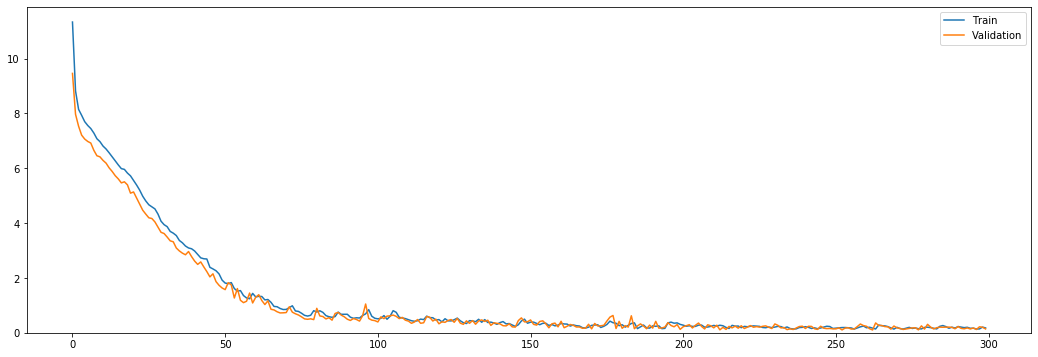

In [18]:
plot_loss(history)

In [19]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.42167032, 0.4947965 , 0.6240332 , 0.665712  , 0.75869226,
        0.84720963, 0.8881588 , 1.0090958 , 1.0881076 ],
       [0.8607474 , 1.0071962 , 1.252337  , 1.3368305 , 1.5201433 ,
        1.6927221 , 1.7737046 , 2.0033653 , 2.1521535 ]], dtype=float32)

**Note**: training seems slower! 

## Implement custom layer

In [20]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coefs,i):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        kurtosis = tensor[2]
        
        if (i in [1,2,3,5,6,7]): 
            
            # shift x-coordinates towards mean for normalised kurtosis of 1
            return tensor1 + sigma_coefs[i]*(1-kurtosis) * tensor2 ;
        else: 
            
            # keep outer(0,8) and middle quantile(4) x-coordinate the same
            return tensor1 + sigma_coefs[i] * tensor2

    return custom_layer

# returns simga coefficients modified to include kurtosis (0-1)
# assumes 9 quantiles to be predicted
def apply_kurtosis(sigma_coefs,kurtosis,nr_of_quantiles=9):
    for i in range(0,nr_of_quantiles):
        if (i in [1,2,3,5,6,7]):
            sigma_coefs[i] = sigma_coefs[i]*(1-kurtosis);
    return sigma_coefs
         
    
def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    kurtosis = Dense(1)(x) # represents kurtosis

    outs = []
    
    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coefs=sigma_coefs,i=i)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma, kurtosis])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [21]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [22]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [23]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 11ms/sample - loss: 37.9384 - q0_loss: 9.2320 - q1_loss: 4.7248 - q2_loss: 2.4416 - q3_loss: 1.7750 - q4_loss: 0.9248 - q5_loss: 1.8986 - q6_loss: 2.5477 - q7_loss: 4.8470 - q8_loss: 7.9017 - val_loss: 10.5129 - val_q0_loss: 2.6015 - val_q1_loss: 1.3251 - val_q2_loss: 0.8729 - val_q3_loss: 0.7640 - val_q4_loss: 0.6328 - val_q5_loss: 0.6100 - val_q6_loss: 0.6301 - val_q7_loss: 0.9186 - val_q8_loss: 2.2335
Epoch 2/300
269/269 [==============================] - 0s 165us/sample - loss: 9.1135 - q0_loss: 2.2072 - q1_loss: 1.0118 - q2_loss: 0.7121 - q3_loss: 0.6349 - q4_loss: 0.5479 - q5_loss: 0.6067 - q6_loss: 0.6594 - q7_loss: 0.9324 - q8_loss: 1.9015 - val_loss: 10.0040 - val_q0_loss: 3.3155 - val_q1_loss: 0.7873 - val_q2_loss: 0.5724 - val_q3_loss: 0.5218 - val_q4_loss: 0.4571 - val_q5_loss: 0.4860 - val_q6_loss: 0.5213 - val_q7_loss: 0.7388 - val_q8_loss: 3.1043
Epoch 3/300
269/269 [==

269/269 [==============================] - 0s 171us/sample - loss: 1.2475 - q0_loss: 0.0712 - q1_loss: 0.0812 - q2_loss: 0.0921 - q3_loss: 0.0984 - q4_loss: 0.1199 - q5_loss: 0.1468 - q6_loss: 0.1601 - q7_loss: 0.2073 - q8_loss: 0.2503 - val_loss: 1.2733 - val_q0_loss: 0.1405 - val_q1_loss: 0.1565 - val_q2_loss: 0.1336 - val_q3_loss: 0.1323 - val_q4_loss: 0.1326 - val_q5_loss: 0.1351 - val_q6_loss: 0.1387 - val_q7_loss: 0.1609 - val_q8_loss: 0.1749
Epoch 19/300
269/269 [==============================] - 0s 169us/sample - loss: 1.1229 - q0_loss: 0.0842 - q1_loss: 0.0931 - q2_loss: 0.0915 - q3_loss: 0.0950 - q4_loss: 0.1085 - q5_loss: 0.1292 - q6_loss: 0.1407 - q7_loss: 0.1816 - q8_loss: 0.2056 - val_loss: 0.6993 - val_q0_loss: 0.0542 - val_q1_loss: 0.0666 - val_q2_loss: 0.0542 - val_q3_loss: 0.0544 - val_q4_loss: 0.0605 - val_q5_loss: 0.0714 - val_q6_loss: 0.0780 - val_q7_loss: 0.1021 - val_q8_loss: 0.1039
Epoch 20/300
269/269 [==============================] - 0s 163us/sample - loss: 0

Epoch 36/300
269/269 [==============================] - 0s 173us/sample - loss: 1.1339 - q0_loss: 0.2740 - q1_loss: 0.1757 - q2_loss: 0.1102 - q3_loss: 0.0915 - q4_loss: 0.0516 - q5_loss: 0.0376 - q6_loss: 0.0479 - q7_loss: 0.1051 - q8_loss: 0.2046 - val_loss: 1.2012 - val_q0_loss: 0.4138 - val_q1_loss: 0.0834 - val_q2_loss: 0.0557 - val_q3_loss: 0.0504 - val_q4_loss: 0.0589 - val_q5_loss: 0.0748 - val_q6_loss: 0.0835 - val_q7_loss: 0.1168 - val_q8_loss: 0.3070
Epoch 37/300
269/269 [==============================] - 0s 182us/sample - loss: 0.8609 - q0_loss: 0.2130 - q1_loss: 0.1242 - q2_loss: 0.0775 - q3_loss: 0.0644 - q4_loss: 0.0384 - q5_loss: 0.0272 - q6_loss: 0.0347 - q7_loss: 0.0805 - q8_loss: 0.1731 - val_loss: 0.7089 - val_q0_loss: 0.1497 - val_q1_loss: 0.1581 - val_q2_loss: 0.0903 - val_q3_loss: 0.0707 - val_q4_loss: 0.0274 - val_q5_loss: 0.0184 - val_q6_loss: 0.0377 - val_q7_loss: 0.1018 - val_q8_loss: 0.0979
Epoch 38/300
269/269 [==============================] - 0s 190us/sam

Epoch 54/300
269/269 [==============================] - 0s 204us/sample - loss: 0.5923 - q0_loss: 0.1001 - q1_loss: 0.0769 - q2_loss: 0.0534 - q3_loss: 0.0477 - q4_loss: 0.0400 - q5_loss: 0.0461 - q6_loss: 0.0514 - q7_loss: 0.0776 - q8_loss: 0.0959 - val_loss: 0.6122 - val_q0_loss: 0.1773 - val_q1_loss: 0.0493 - val_q2_loss: 0.0417 - val_q3_loss: 0.0406 - val_q4_loss: 0.0412 - val_q5_loss: 0.0435 - val_q6_loss: 0.0447 - val_q7_loss: 0.0517 - val_q8_loss: 0.1073
Epoch 55/300
269/269 [==============================] - 0s 171us/sample - loss: 0.5450 - q0_loss: 0.1286 - q1_loss: 0.0818 - q2_loss: 0.0495 - q3_loss: 0.0401 - q4_loss: 0.0234 - q5_loss: 0.0261 - q6_loss: 0.0325 - q7_loss: 0.0605 - q8_loss: 0.1071 - val_loss: 0.5631 - val_q0_loss: 0.1748 - val_q1_loss: 0.0702 - val_q2_loss: 0.0447 - val_q3_loss: 0.0372 - val_q4_loss: 0.0196 - val_q5_loss: 0.0130 - val_q6_loss: 0.0138 - val_q7_loss: 0.0375 - val_q8_loss: 0.1565
Epoch 56/300
269/269 [==============================] - 0s 171us/sam

Epoch 72/300
269/269 [==============================] - 0s 172us/sample - loss: 0.4339 - q0_loss: 0.1000 - q1_loss: 0.0785 - q2_loss: 0.0536 - q3_loss: 0.0471 - q4_loss: 0.0345 - q5_loss: 0.0262 - q6_loss: 0.0251 - q7_loss: 0.0354 - q8_loss: 0.0546 - val_loss: 0.2087 - val_q0_loss: 0.0516 - val_q1_loss: 0.0292 - val_q2_loss: 0.0197 - val_q3_loss: 0.0180 - val_q4_loss: 0.0141 - val_q5_loss: 0.0142 - val_q6_loss: 0.0139 - val_q7_loss: 0.0161 - val_q8_loss: 0.0385
Epoch 73/300
269/269 [==============================] - 0s 182us/sample - loss: 0.3925 - q0_loss: 0.0742 - q1_loss: 0.0515 - q2_loss: 0.0314 - q3_loss: 0.0264 - q4_loss: 0.0199 - q5_loss: 0.0267 - q6_loss: 0.0315 - q7_loss: 0.0505 - q8_loss: 0.0707 - val_loss: 1.3122 - val_q0_loss: 0.2759 - val_q1_loss: 0.2082 - val_q2_loss: 0.0970 - val_q3_loss: 0.0637 - val_q4_loss: 0.0130 - val_q5_loss: 0.0850 - val_q6_loss: 0.1180 - val_q7_loss: 0.2265 - val_q8_loss: 0.2860
Epoch 74/300
269/269 [==============================] - 0s 264us/sam

Epoch 90/300
269/269 [==============================] - 0s 167us/sample - loss: 0.3550 - q0_loss: 0.0665 - q1_loss: 0.0450 - q2_loss: 0.0240 - q3_loss: 0.0194 - q4_loss: 0.0135 - q5_loss: 0.0238 - q6_loss: 0.0293 - q7_loss: 0.0529 - q8_loss: 0.0768 - val_loss: 0.3290 - val_q0_loss: 0.0381 - val_q1_loss: 0.0433 - val_q2_loss: 0.0137 - val_q3_loss: 0.0094 - val_q4_loss: 0.0209 - val_q5_loss: 0.0400 - val_q6_loss: 0.0483 - val_q7_loss: 0.0758 - val_q8_loss: 0.0558
Epoch 91/300
269/269 [==============================] - 0s 182us/sample - loss: 0.3294 - q0_loss: 0.0727 - q1_loss: 0.0591 - q2_loss: 0.0415 - q3_loss: 0.0365 - q4_loss: 0.0279 - q5_loss: 0.0211 - q6_loss: 0.0208 - q7_loss: 0.0301 - q8_loss: 0.0438 - val_loss: 0.7711 - val_q0_loss: 0.1520 - val_q1_loss: 0.1126 - val_q2_loss: 0.1005 - val_q3_loss: 0.0962 - val_q4_loss: 0.0862 - val_q5_loss: 0.0766 - val_q6_loss: 0.0722 - val_q7_loss: 0.0596 - val_q8_loss: 0.0311
Epoch 92/300
269/269 [==============================] - 0s 171us/sam

Epoch 108/300
269/269 [==============================] - 0s 175us/sample - loss: 0.5169 - q0_loss: 0.0943 - q1_loss: 0.0615 - q2_loss: 0.0355 - q3_loss: 0.0291 - q4_loss: 0.0240 - q5_loss: 0.0388 - q6_loss: 0.0482 - q7_loss: 0.0781 - q8_loss: 0.1103 - val_loss: 0.4446 - val_q0_loss: 0.0190 - val_q1_loss: 0.0713 - val_q2_loss: 0.0577 - val_q3_loss: 0.0544 - val_q4_loss: 0.0476 - val_q5_loss: 0.0403 - val_q6_loss: 0.0373 - val_q7_loss: 0.0290 - val_q8_loss: 0.1028
Epoch 109/300
269/269 [==============================] - 0s 193us/sample - loss: 0.5996 - q0_loss: 0.0724 - q1_loss: 0.0692 - q2_loss: 0.0642 - q3_loss: 0.0639 - q4_loss: 0.0650 - q5_loss: 0.0679 - q6_loss: 0.0692 - q7_loss: 0.0748 - q8_loss: 0.0771 - val_loss: 0.3607 - val_q0_loss: 0.0407 - val_q1_loss: 0.0391 - val_q2_loss: 0.0328 - val_q3_loss: 0.0334 - val_q4_loss: 0.0350 - val_q5_loss: 0.0417 - val_q6_loss: 0.0448 - val_q7_loss: 0.0566 - val_q8_loss: 0.0571
Epoch 110/300
269/269 [==============================] - 0s 167us/

Epoch 126/300
269/269 [==============================] - 0s 175us/sample - loss: 0.5521 - q0_loss: 0.1152 - q1_loss: 0.0932 - q2_loss: 0.0646 - q3_loss: 0.0569 - q4_loss: 0.0405 - q5_loss: 0.0300 - q6_loss: 0.0312 - q7_loss: 0.0513 - q8_loss: 0.0708 - val_loss: 0.9327 - val_q0_loss: 0.1253 - val_q1_loss: 0.0835 - val_q2_loss: 0.0927 - val_q3_loss: 0.0959 - val_q4_loss: 0.1026 - val_q5_loss: 0.1097 - val_q6_loss: 0.1127 - val_q7_loss: 0.1228 - val_q8_loss: 0.0996
Epoch 127/300
269/269 [==============================] - 0s 178us/sample - loss: 0.6918 - q0_loss: 0.0924 - q1_loss: 0.0757 - q2_loss: 0.0652 - q3_loss: 0.0640 - q4_loss: 0.0640 - q5_loss: 0.0672 - q6_loss: 0.0697 - q7_loss: 0.0834 - q8_loss: 0.0912 - val_loss: 0.6590 - val_q0_loss: 0.0980 - val_q1_loss: 0.0341 - val_q2_loss: 0.0197 - val_q3_loss: 0.0279 - val_q4_loss: 0.0504 - val_q5_loss: 0.0733 - val_q6_loss: 0.0837 - val_q7_loss: 0.1177 - val_q8_loss: 0.2081
Epoch 128/300
269/269 [==============================] - 0s 175us/

Epoch 144/300
269/269 [==============================] - 0s 190us/sample - loss: 0.1967 - q0_loss: 0.0315 - q1_loss: 0.0230 - q2_loss: 0.0152 - q3_loss: 0.0143 - q4_loss: 0.0139 - q5_loss: 0.0162 - q6_loss: 0.0182 - q7_loss: 0.0265 - q8_loss: 0.0361 - val_loss: 0.1389 - val_q0_loss: 0.0178 - val_q1_loss: 0.0129 - val_q2_loss: 0.0111 - val_q3_loss: 0.0117 - val_q4_loss: 0.0129 - val_q5_loss: 0.0150 - val_q6_loss: 0.0159 - val_q7_loss: 0.0191 - val_q8_loss: 0.0185
Epoch 145/300
269/269 [==============================] - 0s 190us/sample - loss: 0.2199 - q0_loss: 0.0367 - q1_loss: 0.0278 - q2_loss: 0.0182 - q3_loss: 0.0164 - q4_loss: 0.0147 - q5_loss: 0.0173 - q6_loss: 0.0189 - q7_loss: 0.0284 - q8_loss: 0.0359 - val_loss: 0.2830 - val_q0_loss: 0.0579 - val_q1_loss: 0.0448 - val_q2_loss: 0.0194 - val_q3_loss: 0.0136 - val_q4_loss: 0.0086 - val_q5_loss: 0.0214 - val_q6_loss: 0.0283 - val_q7_loss: 0.0502 - val_q8_loss: 0.0584
Epoch 146/300
269/269 [==============================] - 0s 171us/

Epoch 162/300
269/269 [==============================] - 0s 186us/sample - loss: 0.3285 - q0_loss: 0.0516 - q1_loss: 0.0381 - q2_loss: 0.0264 - q3_loss: 0.0244 - q4_loss: 0.0252 - q5_loss: 0.0298 - q6_loss: 0.0327 - q7_loss: 0.0452 - q8_loss: 0.0533 - val_loss: 0.2886 - val_q0_loss: 0.0407 - val_q1_loss: 0.0225 - val_q2_loss: 0.0112 - val_q3_loss: 0.0109 - val_q4_loss: 0.0162 - val_q5_loss: 0.0269 - val_q6_loss: 0.0318 - val_q7_loss: 0.0483 - val_q8_loss: 0.0766
Epoch 163/300
269/269 [==============================] - 0s 175us/sample - loss: 0.2339 - q0_loss: 0.0411 - q1_loss: 0.0314 - q2_loss: 0.0209 - q3_loss: 0.0183 - q4_loss: 0.0146 - q5_loss: 0.0158 - q6_loss: 0.0175 - q7_loss: 0.0290 - q8_loss: 0.0439 - val_loss: 0.3066 - val_q0_loss: 0.0693 - val_q1_loss: 0.0460 - val_q2_loss: 0.0330 - val_q3_loss: 0.0294 - val_q4_loss: 0.0227 - val_q5_loss: 0.0180 - val_q6_loss: 0.0166 - val_q7_loss: 0.0212 - val_q8_loss: 0.0384
Epoch 164/300
269/269 [==============================] - 0s 167us/

Epoch 180/300
269/269 [==============================] - 0s 182us/sample - loss: 0.2991 - q0_loss: 0.0543 - q1_loss: 0.0452 - q2_loss: 0.0346 - q3_loss: 0.0319 - q4_loss: 0.0258 - q5_loss: 0.0213 - q6_loss: 0.0203 - q7_loss: 0.0256 - q8_loss: 0.0360 - val_loss: 0.2442 - val_q0_loss: 0.0380 - val_q1_loss: 0.0252 - val_q2_loss: 0.0139 - val_q3_loss: 0.0119 - val_q4_loss: 0.0116 - val_q5_loss: 0.0181 - val_q6_loss: 0.0222 - val_q7_loss: 0.0383 - val_q8_loss: 0.0587
Epoch 181/300
269/269 [==============================] - 0s 182us/sample - loss: 0.4027 - q0_loss: 0.0778 - q1_loss: 0.0503 - q2_loss: 0.0277 - q3_loss: 0.0226 - q4_loss: 0.0195 - q5_loss: 0.0282 - q6_loss: 0.0340 - q7_loss: 0.0573 - q8_loss: 0.0833 - val_loss: 0.4177 - val_q0_loss: 0.0811 - val_q1_loss: 0.1011 - val_q2_loss: 0.0648 - val_q3_loss: 0.0544 - val_q4_loss: 0.0315 - val_q5_loss: 0.0124 - val_q6_loss: 0.0100 - val_q7_loss: 0.0360 - val_q8_loss: 0.0288
Epoch 182/300
269/269 [==============================] - 0s 175us/

Epoch 198/300
269/269 [==============================] - 0s 171us/sample - loss: 0.3140 - q0_loss: 0.0405 - q1_loss: 0.0337 - q2_loss: 0.0252 - q3_loss: 0.0251 - q4_loss: 0.0265 - q5_loss: 0.0315 - q6_loss: 0.0351 - q7_loss: 0.0467 - q8_loss: 0.0559 - val_loss: 0.2951 - val_q0_loss: 0.0512 - val_q1_loss: 0.0255 - val_q2_loss: 0.0145 - val_q3_loss: 0.0131 - val_q4_loss: 0.0148 - val_q5_loss: 0.0231 - val_q6_loss: 0.0277 - val_q7_loss: 0.0439 - val_q8_loss: 0.0833
Epoch 199/300
269/269 [==============================] - 0s 182us/sample - loss: 0.3595 - q0_loss: 0.0448 - q1_loss: 0.0310 - q2_loss: 0.0226 - q3_loss: 0.0221 - q4_loss: 0.0270 - q5_loss: 0.0363 - q6_loss: 0.0406 - q7_loss: 0.0561 - q8_loss: 0.0669 - val_loss: 0.4729 - val_q0_loss: 0.0407 - val_q1_loss: 0.0552 - val_q2_loss: 0.0523 - val_q3_loss: 0.0526 - val_q4_loss: 0.0534 - val_q5_loss: 0.0539 - val_q6_loss: 0.0544 - val_q7_loss: 0.0556 - val_q8_loss: 0.0917
Epoch 200/300
269/269 [==============================] - 0s 175us/

Epoch 216/300
269/269 [==============================] - 0s 190us/sample - loss: 0.2891 - q0_loss: 0.0541 - q1_loss: 0.0380 - q2_loss: 0.0231 - q3_loss: 0.0198 - q4_loss: 0.0160 - q5_loss: 0.0198 - q6_loss: 0.0238 - q7_loss: 0.0421 - q8_loss: 0.0572 - val_loss: 0.5098 - val_q0_loss: 0.1088 - val_q1_loss: 0.0746 - val_q2_loss: 0.0419 - val_q3_loss: 0.0315 - val_q4_loss: 0.0107 - val_q5_loss: 0.0189 - val_q6_loss: 0.0287 - val_q7_loss: 0.0646 - val_q8_loss: 0.1030
Epoch 217/300
269/269 [==============================] - 0s 186us/sample - loss: 0.4535 - q0_loss: 0.0942 - q1_loss: 0.0730 - q2_loss: 0.0438 - q3_loss: 0.0354 - q4_loss: 0.0187 - q5_loss: 0.0207 - q6_loss: 0.0267 - q7_loss: 0.0547 - q8_loss: 0.0803 - val_loss: 0.4999 - val_q0_loss: 0.1522 - val_q1_loss: 0.0677 - val_q2_loss: 0.0498 - val_q3_loss: 0.0439 - val_q4_loss: 0.0301 - val_q5_loss: 0.0207 - val_q6_loss: 0.0206 - val_q7_loss: 0.0294 - val_q8_loss: 0.1032
Epoch 218/300
269/269 [==============================] - 0s 178us/

Epoch 234/300
269/269 [==============================] - 0s 175us/sample - loss: 0.4339 - q0_loss: 0.0722 - q1_loss: 0.0545 - q2_loss: 0.0402 - q3_loss: 0.0367 - q4_loss: 0.0325 - q5_loss: 0.0361 - q6_loss: 0.0388 - q7_loss: 0.0489 - q8_loss: 0.0673 - val_loss: 0.3464 - val_q0_loss: 0.0670 - val_q1_loss: 0.0843 - val_q2_loss: 0.0569 - val_q3_loss: 0.0493 - val_q4_loss: 0.0327 - val_q5_loss: 0.0184 - val_q6_loss: 0.0145 - val_q7_loss: 0.0190 - val_q8_loss: 0.0229
Epoch 235/300
269/269 [==============================] - 0s 178us/sample - loss: 0.2668 - q0_loss: 0.0597 - q1_loss: 0.0475 - q2_loss: 0.0322 - q3_loss: 0.0284 - q4_loss: 0.0199 - q5_loss: 0.0149 - q6_loss: 0.0145 - q7_loss: 0.0218 - q8_loss: 0.0334 - val_loss: 0.3619 - val_q0_loss: 0.0692 - val_q1_loss: 0.0675 - val_q2_loss: 0.0446 - val_q3_loss: 0.0376 - val_q4_loss: 0.0239 - val_q5_loss: 0.0133 - val_q6_loss: 0.0144 - val_q7_loss: 0.0370 - val_q8_loss: 0.0433
Epoch 236/300
269/269 [==============================] - 0s 178us/

Epoch 252/300
269/269 [==============================] - 0s 186us/sample - loss: 0.3655 - q0_loss: 0.0595 - q1_loss: 0.0460 - q2_loss: 0.0297 - q3_loss: 0.0256 - q4_loss: 0.0247 - q5_loss: 0.0302 - q6_loss: 0.0337 - q7_loss: 0.0504 - q8_loss: 0.0608 - val_loss: 0.5286 - val_q0_loss: 0.1266 - val_q1_loss: 0.0770 - val_q2_loss: 0.0436 - val_q3_loss: 0.0329 - val_q4_loss: 0.0146 - val_q5_loss: 0.0200 - val_q6_loss: 0.0293 - val_q7_loss: 0.0659 - val_q8_loss: 0.1240
Epoch 253/300
269/269 [==============================] - 0s 171us/sample - loss: 0.3529 - q0_loss: 0.0783 - q1_loss: 0.0540 - q2_loss: 0.0310 - q3_loss: 0.0255 - q4_loss: 0.0143 - q5_loss: 0.0168 - q6_loss: 0.0217 - q7_loss: 0.0426 - q8_loss: 0.0632 - val_loss: 0.2572 - val_q0_loss: 0.0504 - val_q1_loss: 0.0358 - val_q2_loss: 0.0228 - val_q3_loss: 0.0199 - val_q4_loss: 0.0126 - val_q5_loss: 0.0114 - val_q6_loss: 0.0117 - val_q7_loss: 0.0211 - val_q8_loss: 0.0704
Epoch 254/300
269/269 [==============================] - 0s 197us/

Epoch 270/300
269/269 [==============================] - 0s 190us/sample - loss: 0.4349 - q0_loss: 0.0333 - q1_loss: 0.0224 - q2_loss: 0.0228 - q3_loss: 0.0272 - q4_loss: 0.0399 - q5_loss: 0.0533 - q6_loss: 0.0596 - q7_loss: 0.0818 - q8_loss: 0.0991 - val_loss: 0.7311 - val_q0_loss: 0.0860 - val_q1_loss: 0.0608 - val_q2_loss: 0.0123 - val_q3_loss: 0.0166 - val_q4_loss: 0.0518 - val_q5_loss: 0.0896 - val_q6_loss: 0.1063 - val_q7_loss: 0.1611 - val_q8_loss: 0.1770
Epoch 271/300
269/269 [==============================] - 0s 182us/sample - loss: 0.4271 - q0_loss: 0.0545 - q1_loss: 0.0437 - q2_loss: 0.0356 - q3_loss: 0.0353 - q4_loss: 0.0397 - q5_loss: 0.0455 - q6_loss: 0.0487 - q7_loss: 0.0591 - q8_loss: 0.0628 - val_loss: 0.4921 - val_q0_loss: 0.0740 - val_q1_loss: 0.0879 - val_q2_loss: 0.0694 - val_q3_loss: 0.0646 - val_q4_loss: 0.0541 - val_q5_loss: 0.0432 - val_q6_loss: 0.0386 - val_q7_loss: 0.0250 - val_q8_loss: 0.0480
Epoch 272/300
269/269 [==============================] - 0s 178us/

Epoch 288/300
269/269 [==============================] - 0s 197us/sample - loss: 0.3222 - q0_loss: 0.0451 - q1_loss: 0.0329 - q2_loss: 0.0183 - q3_loss: 0.0162 - q4_loss: 0.0205 - q5_loss: 0.0294 - q6_loss: 0.0344 - q7_loss: 0.0524 - q8_loss: 0.0723 - val_loss: 0.4406 - val_q0_loss: 0.0279 - val_q1_loss: 0.0149 - val_q2_loss: 0.0318 - val_q3_loss: 0.0379 - val_q4_loss: 0.0517 - val_q5_loss: 0.0659 - val_q6_loss: 0.0721 - val_q7_loss: 0.0925 - val_q8_loss: 0.0714
Epoch 289/300
269/269 [==============================] - 0s 197us/sample - loss: 0.2790 - q0_loss: 0.0282 - q1_loss: 0.0217 - q2_loss: 0.0213 - q3_loss: 0.0229 - q4_loss: 0.0259 - q5_loss: 0.0305 - q6_loss: 0.0329 - q7_loss: 0.0433 - q8_loss: 0.0484 - val_loss: 0.2549 - val_q0_loss: 0.0196 - val_q1_loss: 0.0129 - val_q2_loss: 0.0167 - val_q3_loss: 0.0195 - val_q4_loss: 0.0259 - val_q5_loss: 0.0330 - val_q6_loss: 0.0359 - val_q7_loss: 0.0459 - val_q8_loss: 0.0471
Epoch 290/300
269/269 [==============================] - 0s 193us/

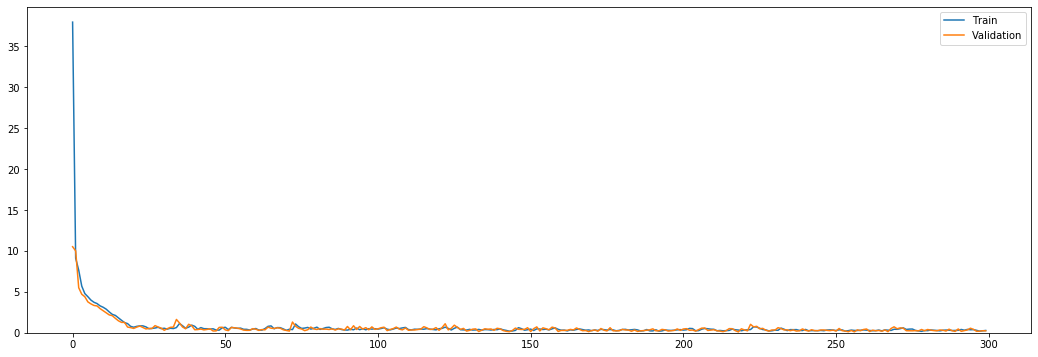

In [24]:
plot_loss(history)

In [25]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.43068644, 0.5188111 , 0.6391861 , 0.67583096, 0.7581285 ,
        0.8404261 , 0.87707067, 0.99744594, 1.0855706 ],
       [0.79297125, 0.9631702 , 1.2262366 , 1.30632   , 1.4861723 ,
        1.6660247 , 1.7461073 , 2.0091743 , 2.1793733 ]], dtype=float32)

## Employ pinball loss

In [26]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [27]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

### With dense layers

In [28]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [29]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 13ms/sample - loss: 5.7314 - q0_loss: 0.0054 - q1_loss: 0.4425 - q2_loss: 0.2930 - q3_loss: 0.7515 - q4_loss: 0.7491 - q5_loss: 0.7944 - q6_loss: 1.0011 - q7_loss: 0.5412 - q8_loss: 1.0664 - val_loss: 4.0819 - val_q0_loss: 0.0048 - val_q1_loss: 0.1458 - val_q2_loss: 0.3621 - val_q3_loss: 1.1216 - val_q4_loss: 0.4286 - val_q5_loss: 0.4552 - val_q6_loss: 1.2071 - val_q7_loss: 0.1453 - val_q8_loss: 0.2138
Epoch 2/300
269/269 [==============================] - 0s 212us/sample - loss: 4.3029 - q0_loss: 0.0055 - q1_loss: 0.1743 - q2_loss: 0.5380 - q3_loss: 1.2263 - q4_loss: 0.3359 - q5_loss: 0.4628 - q6_loss: 1.2811 - q7_loss: 0.1107 - q8_loss: 0.1597 - val_loss: 4.1569 - val_q0_loss: 0.0050 - val_q1_loss: 0.1742 - val_q2_loss: 0.6282 - val_q3_loss: 1.1166 - val_q4_loss: 0.4315 - val_q5_loss: 0.4600 - val_q6_loss: 1.0892 - val_q7_loss: 0.1345 - val_q8_loss: 0.1437
Epoch 3/300
269/269 [=====

269/269 [==============================] - 0s 208us/sample - loss: 1.7563 - q0_loss: 0.0036 - q1_loss: 0.0769 - q2_loss: 0.1475 - q3_loss: 0.5868 - q4_loss: 0.0409 - q5_loss: 0.0427 - q6_loss: 0.7775 - q7_loss: 0.0142 - q8_loss: 0.0784 - val_loss: 1.6369 - val_q0_loss: 0.0030 - val_q1_loss: 0.0627 - val_q2_loss: 0.0944 - val_q3_loss: 0.4963 - val_q4_loss: 0.0658 - val_q5_loss: 0.0315 - val_q6_loss: 0.6643 - val_q7_loss: 0.0650 - val_q8_loss: 0.0806
Epoch 19/300
269/269 [==============================] - 0s 204us/sample - loss: 1.6800 - q0_loss: 0.0035 - q1_loss: 0.0752 - q2_loss: 0.1388 - q3_loss: 0.5697 - q4_loss: 0.0294 - q5_loss: 0.0376 - q6_loss: 0.7406 - q7_loss: 0.0181 - q8_loss: 0.0521 - val_loss: 1.5076 - val_q0_loss: 0.0030 - val_q1_loss: 0.0614 - val_q2_loss: 0.1044 - val_q3_loss: 0.4729 - val_q4_loss: 0.0098 - val_q5_loss: 0.0289 - val_q6_loss: 0.6434 - val_q7_loss: 0.0282 - val_q8_loss: 0.0768
Epoch 20/300
269/269 [==============================] - 0s 234us/sample - loss: 1

269/269 [==============================] - 0s 193us/sample - loss: 1.1246 - q0_loss: 0.0029 - q1_loss: 0.0706 - q2_loss: 0.0833 - q3_loss: 0.4592 - q4_loss: 0.1032 - q5_loss: 0.0234 - q6_loss: 0.3628 - q7_loss: 0.0156 - q8_loss: 9.4781e-04 - val_loss: 1.0019 - val_q0_loss: 0.0025 - val_q1_loss: 0.0605 - val_q2_loss: 0.0711 - val_q3_loss: 0.3782 - val_q4_loss: 0.1059 - val_q5_loss: 0.0046 - val_q6_loss: 0.3097 - val_q7_loss: 0.0118 - val_q8_loss: 5.6085e-04
Epoch 36/300
269/269 [==============================] - 0s 190us/sample - loss: 1.0811 - q0_loss: 0.0029 - q1_loss: 0.0687 - q2_loss: 0.0804 - q3_loss: 0.4443 - q4_loss: 0.0919 - q5_loss: 0.0123 - q6_loss: 0.3506 - q7_loss: 0.0242 - q8_loss: 7.2620e-04 - val_loss: 0.8971 - val_q0_loss: 0.0025 - val_q1_loss: 0.0617 - val_q2_loss: 0.0186 - val_q3_loss: 0.4050 - val_q4_loss: 0.0765 - val_q5_loss: 0.0303 - val_q6_loss: 0.2321 - val_q7_loss: 0.0055 - val_q8_loss: 0.0012
Epoch 37/300
269/269 [==============================] - 0s 186us/samp

269/269 [==============================] - 0s 186us/sample - loss: 0.5678 - q0_loss: 0.0021 - q1_loss: 0.0645 - q2_loss: 0.0223 - q3_loss: 0.3411 - q4_loss: 0.0362 - q5_loss: 0.0351 - q6_loss: 0.0590 - q7_loss: 0.0103 - q8_loss: 0.0018 - val_loss: 0.4796 - val_q0_loss: 0.0017 - val_q1_loss: 0.0571 - val_q2_loss: 0.0108 - val_q3_loss: 0.2866 - val_q4_loss: 0.0183 - val_q5_loss: 0.0245 - val_q6_loss: 0.0383 - val_q7_loss: 0.0082 - val_q8_loss: 0.0012
Epoch 53/300
269/269 [==============================] - 0s 190us/sample - loss: 0.5168 - q0_loss: 0.0020 - q1_loss: 0.0609 - q2_loss: 0.0187 - q3_loss: 0.3172 - q4_loss: 0.0235 - q5_loss: 0.0240 - q6_loss: 0.0552 - q7_loss: 0.0066 - q8_loss: 0.0014 - val_loss: 0.4479 - val_q0_loss: 0.0016 - val_q1_loss: 0.0535 - val_q2_loss: 0.0155 - val_q3_loss: 0.2647 - val_q4_loss: 0.0293 - val_q5_loss: 0.0079 - val_q6_loss: 0.0360 - val_q7_loss: 0.0063 - val_q8_loss: 7.5193e-04
Epoch 54/300
269/269 [==============================] - 0s 193us/sample - los

269/269 [==============================] - 0s 182us/sample - loss: 0.3679 - q0_loss: 0.0011 - q1_loss: 0.0534 - q2_loss: 0.0368 - q3_loss: 0.1904 - q4_loss: 0.0416 - q5_loss: 0.0137 - q6_loss: 0.0260 - q7_loss: 0.0062 - q8_loss: 7.1575e-04 - val_loss: 0.3269 - val_q0_loss: 7.6620e-04 - val_q1_loss: 0.0447 - val_q2_loss: 0.0438 - val_q3_loss: 0.1432 - val_q4_loss: 0.0323 - val_q5_loss: 0.0082 - val_q6_loss: 0.0300 - val_q7_loss: 0.0043 - val_q8_loss: 6.2637e-04
Epoch 70/300
269/269 [==============================] - 0s 182us/sample - loss: 0.3881 - q0_loss: 0.0010 - q1_loss: 0.0529 - q2_loss: 0.0368 - q3_loss: 0.1814 - q4_loss: 0.0570 - q5_loss: 0.0219 - q6_loss: 0.0273 - q7_loss: 0.0061 - q8_loss: 0.0020 - val_loss: 0.3920 - val_q0_loss: 8.0114e-04 - val_q1_loss: 0.0453 - val_q2_loss: 0.0475 - val_q3_loss: 0.1403 - val_q4_loss: 0.0957 - val_q5_loss: 0.0284 - val_q6_loss: 0.0176 - val_q7_loss: 0.0076 - val_q8_loss: 2.9103e-04
Epoch 71/300
269/269 [==============================] - 0s 18

269/269 [==============================] - 0s 212us/sample - loss: 0.1699 - q0_loss: 7.4123e-04 - q1_loss: 0.0435 - q2_loss: 0.0149 - q3_loss: 0.0589 - q4_loss: 0.0221 - q5_loss: 0.0061 - q6_loss: 0.0205 - q7_loss: 0.0030 - q8_loss: 4.8127e-04 - val_loss: 0.1995 - val_q0_loss: 4.2436e-04 - val_q1_loss: 0.0359 - val_q2_loss: 0.0498 - val_q3_loss: 0.0436 - val_q4_loss: 0.0271 - val_q5_loss: 0.0043 - val_q6_loss: 0.0260 - val_q7_loss: 0.0035 - val_q8_loss: 4.5727e-04
Epoch 87/300
269/269 [==============================] - 0s 212us/sample - loss: 0.1789 - q0_loss: 6.9985e-04 - q1_loss: 0.0431 - q2_loss: 0.0189 - q3_loss: 0.0596 - q4_loss: 0.0224 - q5_loss: 0.0066 - q6_loss: 0.0211 - q7_loss: 0.0047 - q8_loss: 6.8399e-04 - val_loss: 0.2242 - val_q0_loss: 0.0011 - val_q1_loss: 0.0373 - val_q2_loss: 0.0527 - val_q3_loss: 0.0398 - val_q4_loss: 0.0393 - val_q5_loss: 0.0143 - val_q6_loss: 0.0314 - val_q7_loss: 0.0025 - val_q8_loss: 7.4388e-04
Epoch 88/300
269/269 [==============================]

269/269 [==============================] - 0s 193us/sample - loss: 0.2698 - q0_loss: 7.4497e-04 - q1_loss: 0.0390 - q2_loss: 0.0408 - q3_loss: 0.0626 - q4_loss: 0.0654 - q5_loss: 0.0198 - q6_loss: 0.0251 - q7_loss: 0.0089 - q8_loss: 7.7546e-04 - val_loss: 0.2440 - val_q0_loss: 5.7109e-04 - val_q1_loss: 0.0296 - val_q2_loss: 0.0307 - val_q3_loss: 0.0326 - val_q4_loss: 0.0666 - val_q5_loss: 0.0450 - val_q6_loss: 0.0165 - val_q7_loss: 0.0044 - val_q8_loss: 0.0126
Epoch 104/300
269/269 [==============================] - 0s 197us/sample - loss: 0.1981 - q0_loss: 7.8528e-04 - q1_loss: 0.0360 - q2_loss: 0.0225 - q3_loss: 0.0562 - q4_loss: 0.0352 - q5_loss: 0.0149 - q6_loss: 0.0200 - q7_loss: 0.0050 - q8_loss: 0.0028 - val_loss: 0.2809 - val_q0_loss: 4.4685e-04 - val_q1_loss: 0.0284 - val_q2_loss: 0.0850 - val_q3_loss: 0.0510 - val_q4_loss: 0.0522 - val_q5_loss: 0.0056 - val_q6_loss: 0.0286 - val_q7_loss: 0.0154 - val_q8_loss: 5.6144e-04
Epoch 105/300
269/269 [==============================] -

269/269 [==============================] - 0s 190us/sample - loss: 0.1939 - q0_loss: 7.6564e-04 - q1_loss: 0.0307 - q2_loss: 0.0216 - q3_loss: 0.0568 - q4_loss: 0.0243 - q5_loss: 0.0220 - q6_loss: 0.0237 - q7_loss: 0.0095 - q8_loss: 9.4444e-04 - val_loss: 0.1828 - val_q0_loss: 5.3305e-04 - val_q1_loss: 0.0208 - val_q2_loss: 0.0101 - val_q3_loss: 0.0319 - val_q4_loss: 0.0275 - val_q5_loss: 0.0429 - val_q6_loss: 0.0161 - val_q7_loss: 0.0101 - val_q8_loss: 0.0170
Epoch 121/300
269/269 [==============================] - 0s 190us/sample - loss: 0.1468 - q0_loss: 7.0968e-04 - q1_loss: 0.0274 - q2_loss: 0.0098 - q3_loss: 0.0524 - q4_loss: 0.0106 - q5_loss: 0.0163 - q6_loss: 0.0205 - q7_loss: 0.0055 - q8_loss: 0.0021 - val_loss: 0.1526 - val_q0_loss: 5.5694e-04 - val_q1_loss: 0.0227 - val_q2_loss: 0.0174 - val_q3_loss: 0.0290 - val_q4_loss: 0.0334 - val_q5_loss: 0.0124 - val_q6_loss: 0.0201 - val_q7_loss: 0.0046 - val_q8_loss: 5.3397e-04
Epoch 122/300
269/269 [==============================] -

269/269 [==============================] - 0s 182us/sample - loss: 0.1377 - q0_loss: 6.5230e-04 - q1_loss: 0.0191 - q2_loss: 0.0172 - q3_loss: 0.0504 - q4_loss: 0.0217 - q5_loss: 0.0058 - q6_loss: 0.0157 - q7_loss: 0.0040 - q8_loss: 4.9961e-04 - val_loss: 0.1293 - val_q0_loss: 4.7327e-04 - val_q1_loss: 0.0150 - val_q2_loss: 0.0186 - val_q3_loss: 0.0280 - val_q4_loss: 0.0303 - val_q5_loss: 0.0132 - val_q6_loss: 0.0142 - val_q7_loss: 0.0035 - val_q8_loss: 3.0214e-04
Epoch 138/300
269/269 [==============================] - 0s 186us/sample - loss: 0.1327 - q0_loss: 6.7295e-04 - q1_loss: 0.0186 - q2_loss: 0.0159 - q3_loss: 0.0506 - q4_loss: 0.0201 - q5_loss: 0.0078 - q6_loss: 0.0174 - q7_loss: 0.0028 - q8_loss: 5.3503e-04 - val_loss: 0.1249 - val_q0_loss: 4.3208e-04 - val_q1_loss: 0.0156 - val_q2_loss: 0.0199 - val_q3_loss: 0.0292 - val_q4_loss: 0.0238 - val_q5_loss: 0.0049 - val_q6_loss: 0.0170 - val_q7_loss: 0.0053 - val_q8_loss: 5.3481e-04
Epoch 139/300
269/269 [=========================

269/269 [==============================] - 0s 186us/sample - loss: 0.1045 - q0_loss: 6.3227e-04 - q1_loss: 0.0102 - q2_loss: 0.0087 - q3_loss: 0.0463 - q4_loss: 0.0134 - q5_loss: 0.0061 - q6_loss: 0.0141 - q7_loss: 0.0031 - q8_loss: 6.1904e-04 - val_loss: 0.0954 - val_q0_loss: 4.2582e-04 - val_q1_loss: 0.0071 - val_q2_loss: 0.0118 - val_q3_loss: 0.0263 - val_q4_loss: 0.0183 - val_q5_loss: 0.0060 - val_q6_loss: 0.0133 - val_q7_loss: 0.0036 - val_q8_loss: 4.3881e-04
Epoch 155/300
269/269 [==============================] - 0s 212us/sample - loss: 0.0964 - q0_loss: 6.4439e-04 - q1_loss: 0.0097 - q2_loss: 0.0076 - q3_loss: 0.0474 - q4_loss: 0.0109 - q5_loss: 0.0050 - q6_loss: 0.0131 - q7_loss: 0.0026 - q8_loss: 4.8606e-04 - val_loss: 0.0807 - val_q0_loss: 3.8688e-04 - val_q1_loss: 0.0058 - val_q2_loss: 0.0057 - val_q3_loss: 0.0260 - val_q4_loss: 0.0093 - val_q5_loss: 0.0046 - val_q6_loss: 0.0165 - val_q7_loss: 0.0022 - val_q8_loss: 5.2928e-04
Epoch 156/300
269/269 [=========================

269/269 [==============================] - 0s 185us/sample - loss: 0.1476 - q0_loss: 6.2676e-04 - q1_loss: 0.0103 - q2_loss: 0.0276 - q3_loss: 0.0477 - q4_loss: 0.0338 - q5_loss: 0.0079 - q6_loss: 0.0109 - q7_loss: 0.0080 - q8_loss: 6.4341e-04 - val_loss: 0.1813 - val_q0_loss: 4.5245e-04 - val_q1_loss: 0.0085 - val_q2_loss: 0.0446 - val_q3_loss: 0.0348 - val_q4_loss: 0.0633 - val_q5_loss: 0.0068 - val_q6_loss: 0.0096 - val_q7_loss: 0.0103 - val_q8_loss: 6.8205e-04
Epoch 172/300
269/269 [==============================] - 0s 186us/sample - loss: 0.1438 - q0_loss: 7.2180e-04 - q1_loss: 0.0094 - q2_loss: 0.0240 - q3_loss: 0.0460 - q4_loss: 0.0268 - q5_loss: 0.0133 - q6_loss: 0.0137 - q7_loss: 0.0061 - q8_loss: 8.0245e-04 - val_loss: 0.0932 - val_q0_loss: 3.9618e-04 - val_q1_loss: 0.0058 - val_q2_loss: 0.0102 - val_q3_loss: 0.0250 - val_q4_loss: 0.0110 - val_q5_loss: 0.0097 - val_q6_loss: 0.0164 - val_q7_loss: 0.0052 - val_q8_loss: 7.7714e-04
Epoch 173/300
269/269 [=========================

269/269 [==============================] - 0s 190us/sample - loss: 0.1013 - q0_loss: 6.0579e-04 - q1_loss: 0.0080 - q2_loss: 0.0127 - q3_loss: 0.0403 - q4_loss: 0.0162 - q5_loss: 0.0070 - q6_loss: 0.0097 - q7_loss: 0.0038 - q8_loss: 7.1076e-04 - val_loss: 0.0994 - val_q0_loss: 4.4094e-04 - val_q1_loss: 0.0059 - val_q2_loss: 0.0200 - val_q3_loss: 0.0242 - val_q4_loss: 0.0233 - val_q5_loss: 0.0042 - val_q6_loss: 0.0086 - val_q7_loss: 0.0055 - val_q8_loss: 5.8102e-04
Epoch 189/300
269/269 [==============================] - 0s 188us/sample - loss: 0.0958 - q0_loss: 5.8955e-04 - q1_loss: 0.0080 - q2_loss: 0.0111 - q3_loss: 0.0422 - q4_loss: 0.0140 - q5_loss: 0.0084 - q6_loss: 0.0089 - q7_loss: 0.0034 - q8_loss: 7.1288e-04 - val_loss: 0.0892 - val_q0_loss: 3.9489e-04 - val_q1_loss: 0.0054 - val_q2_loss: 0.0161 - val_q3_loss: 0.0228 - val_q4_loss: 0.0178 - val_q5_loss: 0.0078 - val_q6_loss: 0.0077 - val_q7_loss: 0.0046 - val_q8_loss: 5.5040e-04
Epoch 190/300
269/269 [=========================

269/269 [==============================] - 0s 208us/sample - loss: 0.0924 - q0_loss: 5.3451e-04 - q1_loss: 0.0072 - q2_loss: 0.0099 - q3_loss: 0.0378 - q4_loss: 0.0153 - q5_loss: 0.0091 - q6_loss: 0.0087 - q7_loss: 0.0028 - q8_loss: 7.8462e-04 - val_loss: 0.0854 - val_q0_loss: 3.9288e-04 - val_q1_loss: 0.0044 - val_q2_loss: 0.0154 - val_q3_loss: 0.0212 - val_q4_loss: 0.0189 - val_q5_loss: 0.0121 - val_q6_loss: 0.0046 - val_q7_loss: 0.0026 - val_q8_loss: 4.1826e-04
Epoch 206/300
269/269 [==============================] - 0s 197us/sample - loss: 0.1263 - q0_loss: 7.2321e-04 - q1_loss: 0.0095 - q2_loss: 0.0211 - q3_loss: 0.0392 - q4_loss: 0.0205 - q5_loss: 0.0169 - q6_loss: 0.0102 - q7_loss: 0.0074 - q8_loss: 0.0010 - val_loss: 0.1197 - val_q0_loss: 0.0017 - val_q1_loss: 0.0050 - val_q2_loss: 0.0072 - val_q3_loss: 0.0271 - val_q4_loss: 0.0295 - val_q5_loss: 0.0209 - val_q6_loss: 0.0177 - val_q7_loss: 0.0052 - val_q8_loss: 0.0011
Epoch 207/300
269/269 [==============================] - 0s 

269/269 [==============================] - 0s 197us/sample - loss: 0.0880 - q0_loss: 8.1515e-04 - q1_loss: 0.0081 - q2_loss: 0.0114 - q3_loss: 0.0345 - q4_loss: 0.0110 - q5_loss: 0.0097 - q6_loss: 0.0068 - q7_loss: 0.0049 - q8_loss: 9.5314e-04 - val_loss: 0.0978 - val_q0_loss: 6.5394e-04 - val_q1_loss: 0.0053 - val_q2_loss: 0.0162 - val_q3_loss: 0.0203 - val_q4_loss: 0.0196 - val_q5_loss: 0.0108 - val_q6_loss: 0.0089 - val_q7_loss: 0.0052 - val_q8_loss: 6.9806e-04
Epoch 223/300
269/269 [==============================] - 0s 208us/sample - loss: 0.0867 - q0_loss: 8.1235e-04 - q1_loss: 0.0074 - q2_loss: 0.0096 - q3_loss: 0.0347 - q4_loss: 0.0138 - q5_loss: 0.0078 - q6_loss: 0.0073 - q7_loss: 0.0039 - q8_loss: 7.3008e-04 - val_loss: 0.0864 - val_q0_loss: 6.5226e-04 - val_q1_loss: 0.0045 - val_q2_loss: 0.0143 - val_q3_loss: 0.0200 - val_q4_loss: 0.0196 - val_q5_loss: 0.0121 - val_q6_loss: 0.0064 - val_q7_loss: 0.0035 - val_q8_loss: 4.6765e-04
Epoch 224/300
269/269 [=========================

269/269 [==============================] - 0s 201us/sample - loss: 0.0728 - q0_loss: 6.6693e-04 - q1_loss: 0.0076 - q2_loss: 0.0081 - q3_loss: 0.0301 - q4_loss: 0.0082 - q5_loss: 0.0080 - q6_loss: 0.0054 - q7_loss: 0.0043 - q8_loss: 7.3492e-04 - val_loss: 0.0618 - val_q0_loss: 4.7947e-04 - val_q1_loss: 0.0043 - val_q2_loss: 0.0070 - val_q3_loss: 0.0185 - val_q4_loss: 0.0076 - val_q5_loss: 0.0069 - val_q6_loss: 0.0051 - val_q7_loss: 0.0036 - val_q8_loss: 6.9607e-04
Epoch 240/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0662 - q0_loss: 6.7320e-04 - q1_loss: 0.0074 - q2_loss: 0.0071 - q3_loss: 0.0321 - q4_loss: 0.0077 - q5_loss: 0.0054 - q6_loss: 0.0045 - q7_loss: 0.0034 - q8_loss: 7.0741e-04 - val_loss: 0.0562 - val_q0_loss: 4.4549e-04 - val_q1_loss: 0.0042 - val_q2_loss: 0.0045 - val_q3_loss: 0.0180 - val_q4_loss: 0.0074 - val_q5_loss: 0.0064 - val_q6_loss: 0.0058 - val_q7_loss: 0.0036 - val_q8_loss: 7.1748e-04
Epoch 241/300
269/269 [=========================

269/269 [==============================] - 0s 190us/sample - loss: 0.0795 - q0_loss: 5.4651e-04 - q1_loss: 0.0065 - q2_loss: 0.0116 - q3_loss: 0.0280 - q4_loss: 0.0155 - q5_loss: 0.0063 - q6_loss: 0.0065 - q7_loss: 0.0030 - q8_loss: 7.6291e-04 - val_loss: 0.0701 - val_q0_loss: 3.3365e-04 - val_q1_loss: 0.0034 - val_q2_loss: 0.0048 - val_q3_loss: 0.0194 - val_q4_loss: 0.0151 - val_q5_loss: 0.0087 - val_q6_loss: 0.0089 - val_q7_loss: 0.0025 - val_q8_loss: 6.9239e-04
Epoch 257/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0665 - q0_loss: 5.2671e-04 - q1_loss: 0.0067 - q2_loss: 0.0089 - q3_loss: 0.0268 - q4_loss: 0.0104 - q5_loss: 0.0048 - q6_loss: 0.0049 - q7_loss: 0.0022 - q8_loss: 5.8636e-04 - val_loss: 0.0498 - val_q0_loss: 3.6757e-04 - val_q1_loss: 0.0037 - val_q2_loss: 0.0099 - val_q3_loss: 0.0145 - val_q4_loss: 0.0075 - val_q5_loss: 0.0033 - val_q6_loss: 0.0026 - val_q7_loss: 0.0022 - val_q8_loss: 4.7213e-04
Epoch 258/300
269/269 [=========================

269/269 [==============================] - 0s 190us/sample - loss: 0.0796 - q0_loss: 4.9851e-04 - q1_loss: 0.0079 - q2_loss: 0.0121 - q3_loss: 0.0244 - q4_loss: 0.0122 - q5_loss: 0.0097 - q6_loss: 0.0062 - q7_loss: 0.0057 - q8_loss: 7.9782e-04 - val_loss: 0.0581 - val_q0_loss: 2.9522e-04 - val_q1_loss: 0.0043 - val_q2_loss: 0.0046 - val_q3_loss: 0.0148 - val_q4_loss: 0.0083 - val_q5_loss: 0.0094 - val_q6_loss: 0.0070 - val_q7_loss: 0.0044 - val_q8_loss: 7.8835e-04
Epoch 274/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0752 - q0_loss: 5.4355e-04 - q1_loss: 0.0070 - q2_loss: 0.0121 - q3_loss: 0.0242 - q4_loss: 0.0121 - q5_loss: 0.0086 - q6_loss: 0.0060 - q7_loss: 0.0038 - q8_loss: 8.1375e-04 - val_loss: 0.0589 - val_q0_loss: 3.0716e-04 - val_q1_loss: 0.0039 - val_q2_loss: 0.0083 - val_q3_loss: 0.0144 - val_q4_loss: 0.0096 - val_q5_loss: 0.0057 - val_q6_loss: 0.0057 - val_q7_loss: 0.0033 - val_q8_loss: 6.9210e-04
Epoch 275/300
269/269 [=========================

Epoch 290/300
269/269 [==============================] - 0s 219us/sample - loss: 0.0608 - q0_loss: 4.9714e-04 - q1_loss: 0.0068 - q2_loss: 0.0084 - q3_loss: 0.0194 - q4_loss: 0.0096 - q5_loss: 0.0061 - q6_loss: 0.0042 - q7_loss: 0.0035 - q8_loss: 7.3725e-04 - val_loss: 0.0709 - val_q0_loss: 4.2129e-04 - val_q1_loss: 0.0076 - val_q2_loss: 0.0045 - val_q3_loss: 0.0108 - val_q4_loss: 0.0079 - val_q5_loss: 0.0197 - val_q6_loss: 0.0136 - val_q7_loss: 0.0057 - val_q8_loss: 9.1479e-04
Epoch 291/300
269/269 [==============================] - 0s 208us/sample - loss: 0.0598 - q0_loss: 4.7588e-04 - q1_loss: 0.0067 - q2_loss: 0.0067 - q3_loss: 0.0177 - q4_loss: 0.0062 - q5_loss: 0.0099 - q6_loss: 0.0061 - q7_loss: 0.0044 - q8_loss: 0.0011 - val_loss: 0.0358 - val_q0_loss: 3.3970e-04 - val_q1_loss: 0.0035 - val_q2_loss: 0.0048 - val_q3_loss: 0.0101 - val_q4_loss: 0.0029 - val_q5_loss: 0.0043 - val_q6_loss: 0.0031 - val_q7_loss: 0.0025 - val_q8_loss: 5.5603e-04
Epoch 292/300
269/269 [===============

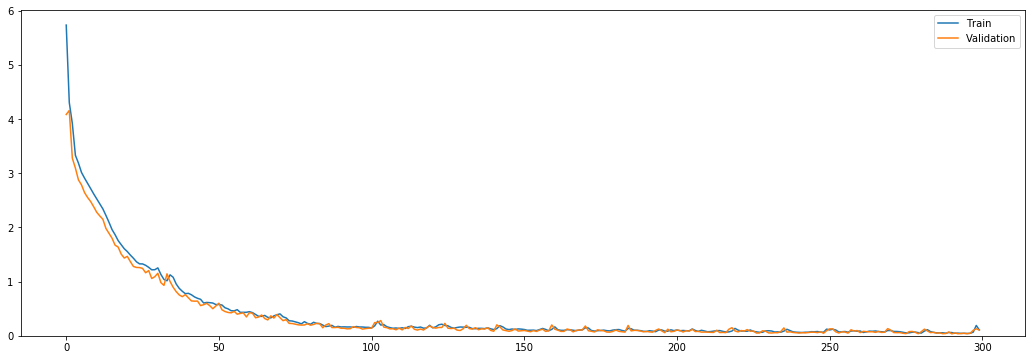

In [30]:
plot_loss(history)

In [31]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.28156927, 0.3768316 , 0.5010469 , 0.6332152 , 0.7026884 ,
        0.853904  , 0.8779509 , 1.254813  , 1.1878681 ],
       [0.529585  , 0.20502627, 1.1387428 , 1.1314514 , 1.4684663 ,
        1.7122128 , 1.7707304 , 2.3365316 , 2.4275882 ]], dtype=float32)

### With distribution layer

In [32]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [33]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 11ms/sample - loss: 16.2873 - q0_loss: 2.3496 - q1_loss: 0.1314 - q2_loss: 0.5100 - q3_loss: 0.7061 - q4_loss: 1.1147 - q5_loss: 1.3993 - q6_loss: 1.5451 - q7_loss: 1.8226 - q8_loss: 6.2321 - val_loss: 7.5829 - val_q0_loss: 0.5380 - val_q1_loss: 0.0531 - val_q2_loss: 0.2494 - val_q3_loss: 0.3570 - val_q4_loss: 0.6199 - val_q5_loss: 0.9209 - val_q6_loss: 1.0444 - val_q7_loss: 1.2912 - val_q8_loss: 1.8327
Epoch 2/300
269/269 [==============================] - 0s 208us/sample - loss: 5.9656 - q0_loss: 0.3245 - q1_loss: 0.5876 - q2_loss: 0.3244 - q3_loss: 0.3066 - q4_loss: 0.4387 - q5_loss: 0.7769 - q6_loss: 0.9588 - q7_loss: 1.5322 - q8_loss: 0.5357 - val_loss: 3.9556 - val_q0_loss: 1.4835 - val_q1_loss: 0.3035 - val_q2_loss: 0.4133 - val_q3_loss: 0.4373 - val_q4_loss: 0.4235 - val_q5_loss: 0.3416 - val_q6_loss: 0.3039 - val_q7_loss: 0.2460 - val_q8_loss: 0.2977
Epoch 3/300
269/269 [====

269/269 [==============================] - 0s 201us/sample - loss: 0.2568 - q0_loss: 0.0088 - q1_loss: 0.0084 - q2_loss: 0.0330 - q3_loss: 0.0451 - q4_loss: 0.0611 - q5_loss: 0.0482 - q6_loss: 0.0355 - q7_loss: 0.0084 - q8_loss: 0.0032 - val_loss: 0.2190 - val_q0_loss: 0.0041 - val_q1_loss: 0.0074 - val_q2_loss: 0.0255 - val_q3_loss: 0.0363 - val_q4_loss: 0.0566 - val_q5_loss: 0.0404 - val_q6_loss: 0.0302 - val_q7_loss: 0.0079 - val_q8_loss: 0.0040
Epoch 19/300
269/269 [==============================] - 0s 193us/sample - loss: 0.2314 - q0_loss: 0.0042 - q1_loss: 0.0101 - q2_loss: 0.0374 - q3_loss: 0.0458 - q4_loss: 0.0526 - q5_loss: 0.0387 - q6_loss: 0.0261 - q7_loss: 0.0075 - q8_loss: 0.0030 - val_loss: 0.1926 - val_q0_loss: 0.0087 - val_q1_loss: 0.0097 - val_q2_loss: 0.0270 - val_q3_loss: 0.0348 - val_q4_loss: 0.0424 - val_q5_loss: 0.0283 - val_q6_loss: 0.0190 - val_q7_loss: 0.0056 - val_q8_loss: 0.0031
Epoch 20/300
269/269 [==============================] - 0s 227us/sample - loss: 0

Epoch 36/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0737 - q0_loss: 0.0025 - q1_loss: 0.0047 - q2_loss: 0.0114 - q3_loss: 0.0128 - q4_loss: 0.0116 - q5_loss: 0.0126 - q6_loss: 0.0112 - q7_loss: 0.0044 - q8_loss: 0.0025 - val_loss: 0.0564 - val_q0_loss: 0.0031 - val_q1_loss: 0.0027 - val_q2_loss: 0.0085 - val_q3_loss: 0.0084 - val_q4_loss: 0.0042 - val_q5_loss: 0.0117 - val_q6_loss: 0.0107 - val_q7_loss: 0.0031 - val_q8_loss: 0.0032
Epoch 37/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0648 - q0_loss: 0.0025 - q1_loss: 0.0044 - q2_loss: 0.0106 - q3_loss: 0.0117 - q4_loss: 0.0096 - q5_loss: 0.0101 - q6_loss: 0.0095 - q7_loss: 0.0042 - q8_loss: 0.0025 - val_loss: 0.0561 - val_q0_loss: 0.0026 - val_q1_loss: 0.0024 - val_q2_loss: 0.0072 - val_q3_loss: 0.0068 - val_q4_loss: 0.0060 - val_q5_loss: 0.0121 - val_q6_loss: 0.0108 - val_q7_loss: 0.0030 - val_q8_loss: 0.0028
Epoch 38/300
269/269 [==============================] - 0s 197us/sam

Epoch 54/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0498 - q0_loss: 0.0019 - q1_loss: 0.0025 - q2_loss: 0.0072 - q3_loss: 0.0081 - q4_loss: 0.0083 - q5_loss: 0.0091 - q6_loss: 0.0078 - q7_loss: 0.0027 - q8_loss: 0.0019 - val_loss: 0.0565 - val_q0_loss: 0.0022 - val_q1_loss: 0.0019 - val_q2_loss: 0.0057 - val_q3_loss: 0.0056 - val_q4_loss: 0.0108 - val_q5_loss: 0.0139 - val_q6_loss: 0.0118 - val_q7_loss: 0.0030 - val_q8_loss: 0.0024
Epoch 55/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0510 - q0_loss: 0.0017 - q1_loss: 0.0030 - q2_loss: 0.0081 - q3_loss: 0.0094 - q4_loss: 0.0107 - q5_loss: 0.0080 - q6_loss: 0.0067 - q7_loss: 0.0026 - q8_loss: 0.0017 - val_loss: 0.0473 - val_q0_loss: 0.0020 - val_q1_loss: 0.0026 - val_q2_loss: 0.0099 - val_q3_loss: 0.0114 - val_q4_loss: 0.0076 - val_q5_loss: 0.0050 - val_q6_loss: 0.0054 - val_q7_loss: 0.0020 - val_q8_loss: 0.0020
Epoch 56/300
269/269 [==============================] - 0s 197us/sam

Epoch 72/300
269/269 [==============================] - 0s 204us/sample - loss: 0.0676 - q0_loss: 0.0021 - q1_loss: 0.0045 - q2_loss: 0.0116 - q3_loss: 0.0137 - q4_loss: 0.0133 - q5_loss: 0.0080 - q6_loss: 0.0074 - q7_loss: 0.0039 - q8_loss: 0.0020 - val_loss: 0.0471 - val_q0_loss: 0.0019 - val_q1_loss: 0.0015 - val_q2_loss: 0.0049 - val_q3_loss: 0.0067 - val_q4_loss: 0.0091 - val_q5_loss: 0.0097 - val_q6_loss: 0.0083 - val_q7_loss: 0.0022 - val_q8_loss: 0.0021
Epoch 73/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0461 - q0_loss: 0.0016 - q1_loss: 0.0036 - q2_loss: 0.0067 - q3_loss: 0.0071 - q4_loss: 0.0071 - q5_loss: 0.0085 - q6_loss: 0.0077 - q7_loss: 0.0034 - q8_loss: 0.0017 - val_loss: 0.0523 - val_q0_loss: 0.0017 - val_q1_loss: 0.0017 - val_q2_loss: 0.0050 - val_q3_loss: 0.0073 - val_q4_loss: 0.0123 - val_q5_loss: 0.0112 - val_q6_loss: 0.0091 - val_q7_loss: 0.0034 - val_q8_loss: 0.0020
Epoch 74/300
269/269 [==============================] - 0s 186us/sam

Epoch 90/300
269/269 [==============================] - 0s 234us/sample - loss: 0.0731 - q0_loss: 0.0019 - q1_loss: 0.0034 - q2_loss: 0.0079 - q3_loss: 0.0080 - q4_loss: 0.0145 - q5_loss: 0.0159 - q6_loss: 0.0137 - q7_loss: 0.0049 - q8_loss: 0.0021 - val_loss: 0.0691 - val_q0_loss: 0.0024 - val_q1_loss: 0.0037 - val_q2_loss: 0.0144 - val_q3_loss: 0.0171 - val_q4_loss: 0.0137 - val_q5_loss: 0.0041 - val_q6_loss: 0.0057 - val_q7_loss: 0.0024 - val_q8_loss: 0.0022
Epoch 91/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0564 - q0_loss: 0.0018 - q1_loss: 0.0046 - q2_loss: 0.0105 - q3_loss: 0.0121 - q4_loss: 0.0108 - q5_loss: 0.0061 - q6_loss: 0.0061 - q7_loss: 0.0031 - q8_loss: 0.0017 - val_loss: 0.0794 - val_q0_loss: 0.0026 - val_q1_loss: 0.0037 - val_q2_loss: 0.0140 - val_q3_loss: 0.0161 - val_q4_loss: 0.0104 - val_q5_loss: 0.0114 - val_q6_loss: 0.0114 - val_q7_loss: 0.0050 - val_q8_loss: 0.0024
Epoch 92/300
269/269 [==============================] - 0s 193us/sam

Epoch 108/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0551 - q0_loss: 0.0019 - q1_loss: 0.0051 - q2_loss: 0.0087 - q3_loss: 0.0093 - q4_loss: 0.0089 - q5_loss: 0.0083 - q6_loss: 0.0072 - q7_loss: 0.0030 - q8_loss: 0.0019 - val_loss: 0.0574 - val_q0_loss: 0.0021 - val_q1_loss: 0.0015 - val_q2_loss: 0.0065 - val_q3_loss: 0.0085 - val_q4_loss: 0.0115 - val_q5_loss: 0.0113 - val_q6_loss: 0.0110 - val_q7_loss: 0.0078 - val_q8_loss: 0.0019
Epoch 109/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0376 - q0_loss: 0.0017 - q1_loss: 0.0019 - q2_loss: 0.0048 - q3_loss: 0.0055 - q4_loss: 0.0063 - q5_loss: 0.0065 - q6_loss: 0.0057 - q7_loss: 0.0032 - q8_loss: 0.0018 - val_loss: 0.0421 - val_q0_loss: 0.0020 - val_q1_loss: 0.0018 - val_q2_loss: 0.0068 - val_q3_loss: 0.0077 - val_q4_loss: 0.0063 - val_q5_loss: 0.0063 - val_q6_loss: 0.0058 - val_q7_loss: 0.0020 - val_q8_loss: 0.0020
Epoch 110/300
269/269 [==============================] - 0s 190us/

Epoch 126/300
269/269 [==============================] - 0s 204us/sample - loss: 0.0784 - q0_loss: 0.0024 - q1_loss: 0.0055 - q2_loss: 0.0141 - q3_loss: 0.0166 - q4_loss: 0.0158 - q5_loss: 0.0104 - q6_loss: 0.0085 - q7_loss: 0.0025 - q8_loss: 0.0022 - val_loss: 0.0814 - val_q0_loss: 0.0027 - val_q1_loss: 0.0030 - val_q2_loss: 0.0080 - val_q3_loss: 0.0072 - val_q4_loss: 0.0142 - val_q5_loss: 0.0197 - val_q6_loss: 0.0168 - val_q7_loss: 0.0044 - val_q8_loss: 0.0030
Epoch 127/300
269/269 [==============================] - 0s 207us/sample - loss: 0.0704 - q0_loss: 0.0021 - q1_loss: 0.0041 - q2_loss: 0.0096 - q3_loss: 0.0109 - q4_loss: 0.0121 - q5_loss: 0.0124 - q6_loss: 0.0112 - q7_loss: 0.0061 - q8_loss: 0.0022 - val_loss: 0.0522 - val_q0_loss: 0.0023 - val_q1_loss: 0.0026 - val_q2_loss: 0.0082 - val_q3_loss: 0.0081 - val_q4_loss: 0.0051 - val_q5_loss: 0.0121 - val_q6_loss: 0.0109 - val_q7_loss: 0.0031 - val_q8_loss: 0.0025
Epoch 128/300
269/269 [==============================] - 0s 197us/

Epoch 144/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0526 - q0_loss: 0.0021 - q1_loss: 0.0042 - q2_loss: 0.0064 - q3_loss: 0.0069 - q4_loss: 0.0093 - q5_loss: 0.0091 - q6_loss: 0.0083 - q7_loss: 0.0043 - q8_loss: 0.0021 - val_loss: 0.0459 - val_q0_loss: 0.0025 - val_q1_loss: 0.0021 - val_q2_loss: 0.0074 - val_q3_loss: 0.0081 - val_q4_loss: 0.0059 - val_q5_loss: 0.0068 - val_q6_loss: 0.0066 - val_q7_loss: 0.0021 - val_q8_loss: 0.0025
Epoch 145/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0565 - q0_loss: 0.0023 - q1_loss: 0.0038 - q2_loss: 0.0091 - q3_loss: 0.0101 - q4_loss: 0.0073 - q5_loss: 0.0083 - q6_loss: 0.0082 - q7_loss: 0.0040 - q8_loss: 0.0022 - val_loss: 0.0542 - val_q0_loss: 0.0024 - val_q1_loss: 0.0022 - val_q2_loss: 0.0059 - val_q3_loss: 0.0051 - val_q4_loss: 0.0089 - val_q5_loss: 0.0136 - val_q6_loss: 0.0117 - val_q7_loss: 0.0031 - val_q8_loss: 0.0026
Epoch 146/300
269/269 [==============================] - 0s 190us/

Epoch 162/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0624 - q0_loss: 0.0017 - q1_loss: 0.0024 - q2_loss: 0.0068 - q3_loss: 0.0083 - q4_loss: 0.0132 - q5_loss: 0.0132 - q6_loss: 0.0112 - q7_loss: 0.0032 - q8_loss: 0.0018 - val_loss: 0.0704 - val_q0_loss: 0.0023 - val_q1_loss: 0.0039 - val_q2_loss: 0.0158 - val_q3_loss: 0.0194 - val_q4_loss: 0.0178 - val_q5_loss: 0.0029 - val_q6_loss: 0.0041 - val_q7_loss: 0.0022 - val_q8_loss: 0.0020
Epoch 163/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0578 - q0_loss: 0.0017 - q1_loss: 0.0029 - q2_loss: 0.0103 - q3_loss: 0.0123 - q4_loss: 0.0132 - q5_loss: 0.0077 - q6_loss: 0.0062 - q7_loss: 0.0020 - q8_loss: 0.0016 - val_loss: 0.0463 - val_q0_loss: 0.0016 - val_q1_loss: 0.0013 - val_q2_loss: 0.0028 - val_q3_loss: 0.0034 - val_q4_loss: 0.0119 - val_q5_loss: 0.0122 - val_q6_loss: 0.0099 - val_q7_loss: 0.0024 - val_q8_loss: 0.0018
Epoch 164/300
269/269 [==============================] - 0s 201us/

Epoch 180/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0362 - q0_loss: 0.0014 - q1_loss: 0.0021 - q2_loss: 0.0049 - q3_loss: 0.0059 - q4_loss: 0.0065 - q5_loss: 0.0061 - q6_loss: 0.0053 - q7_loss: 0.0020 - q8_loss: 0.0014 - val_loss: 0.0364 - val_q0_loss: 0.0012 - val_q1_loss: 0.0058 - val_q2_loss: 0.0065 - val_q3_loss: 0.0071 - val_q4_loss: 0.0071 - val_q5_loss: 0.0052 - val_q6_loss: 0.0039 - val_q7_loss: 0.0010 - val_q8_loss: 0.0014
Epoch 181/300
269/269 [==============================] - 0s 204us/sample - loss: 0.0373 - q0_loss: 0.0014 - q1_loss: 0.0021 - q2_loss: 0.0054 - q3_loss: 0.0064 - q4_loss: 0.0065 - q5_loss: 0.0063 - q6_loss: 0.0054 - q7_loss: 0.0019 - q8_loss: 0.0014 - val_loss: 0.0313 - val_q0_loss: 0.0014 - val_q1_loss: 0.0011 - val_q2_loss: 0.0036 - val_q3_loss: 0.0043 - val_q4_loss: 0.0059 - val_q5_loss: 0.0066 - val_q6_loss: 0.0057 - val_q7_loss: 0.0015 - val_q8_loss: 0.0016
Epoch 182/300
269/269 [==============================] - 0s 204us/

Epoch 198/300
269/269 [==============================] - 0s 201us/sample - loss: 0.0457 - q0_loss: 0.0015 - q1_loss: 0.0021 - q2_loss: 0.0058 - q3_loss: 0.0070 - q4_loss: 0.0074 - q5_loss: 0.0082 - q6_loss: 0.0076 - q7_loss: 0.0041 - q8_loss: 0.0016 - val_loss: 0.0654 - val_q0_loss: 0.0014 - val_q1_loss: 0.0102 - val_q2_loss: 0.0135 - val_q3_loss: 0.0148 - val_q4_loss: 0.0144 - val_q5_loss: 0.0101 - val_q6_loss: 0.0076 - val_q7_loss: 0.0016 - val_q8_loss: 0.0017
Epoch 199/300
269/269 [==============================] - 0s 201us/sample - loss: 0.0541 - q0_loss: 0.0016 - q1_loss: 0.0059 - q2_loss: 0.0102 - q3_loss: 0.0115 - q4_loss: 0.0099 - q5_loss: 0.0059 - q6_loss: 0.0054 - q7_loss: 0.0018 - q8_loss: 0.0016 - val_loss: 0.0568 - val_q0_loss: 0.0016 - val_q1_loss: 0.0070 - val_q2_loss: 0.0114 - val_q3_loss: 0.0126 - val_q4_loss: 0.0114 - val_q5_loss: 0.0053 - val_q6_loss: 0.0036 - val_q7_loss: 0.0020 - val_q8_loss: 0.0016
Epoch 200/300
269/269 [==============================] - 0s 202us/

Epoch 216/300
269/269 [==============================] - 0s 219us/sample - loss: 0.0707 - q0_loss: 0.0023 - q1_loss: 0.0044 - q2_loss: 0.0093 - q3_loss: 0.0098 - q4_loss: 0.0115 - q5_loss: 0.0134 - q6_loss: 0.0120 - q7_loss: 0.0053 - q8_loss: 0.0024 - val_loss: 0.0477 - val_q0_loss: 0.0022 - val_q1_loss: 0.0032 - val_q2_loss: 0.0062 - val_q3_loss: 0.0074 - val_q4_loss: 0.0062 - val_q5_loss: 0.0054 - val_q6_loss: 0.0056 - val_q7_loss: 0.0052 - val_q8_loss: 0.0021
Epoch 217/300
269/269 [==============================] - 0s 204us/sample - loss: 0.0665 - q0_loss: 0.0022 - q1_loss: 0.0066 - q2_loss: 0.0129 - q3_loss: 0.0142 - q4_loss: 0.0113 - q5_loss: 0.0076 - q6_loss: 0.0071 - q7_loss: 0.0030 - q8_loss: 0.0022 - val_loss: 0.0598 - val_q0_loss: 0.0026 - val_q1_loss: 0.0032 - val_q2_loss: 0.0129 - val_q3_loss: 0.0155 - val_q4_loss: 0.0133 - val_q5_loss: 0.0055 - val_q6_loss: 0.0051 - val_q7_loss: 0.0027 - val_q8_loss: 0.0024
Epoch 218/300
269/269 [==============================] - 0s 208us/

Epoch 234/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0549 - q0_loss: 0.0021 - q1_loss: 0.0043 - q2_loss: 0.0098 - q3_loss: 0.0112 - q4_loss: 0.0089 - q5_loss: 0.0062 - q6_loss: 0.0063 - q7_loss: 0.0029 - q8_loss: 0.0021 - val_loss: 0.0282 - val_q0_loss: 0.0019 - val_q1_loss: 9.7663e-04 - val_q2_loss: 0.0042 - val_q3_loss: 0.0053 - val_q4_loss: 0.0056 - val_q5_loss: 0.0046 - val_q6_loss: 0.0037 - val_q7_loss: 8.5987e-04 - val_q8_loss: 0.0019
Epoch 235/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0332 - q0_loss: 0.0018 - q1_loss: 0.0022 - q2_loss: 0.0044 - q3_loss: 0.0051 - q4_loss: 0.0052 - q5_loss: 0.0056 - q6_loss: 0.0048 - q7_loss: 0.0025 - q8_loss: 0.0018 - val_loss: 0.0291 - val_q0_loss: 0.0020 - val_q1_loss: 0.0012 - val_q2_loss: 0.0041 - val_q3_loss: 0.0044 - val_q4_loss: 0.0039 - val_q5_loss: 0.0053 - val_q6_loss: 0.0049 - val_q7_loss: 0.0014 - val_q8_loss: 0.0021
Epoch 236/300
269/269 [==============================] - 0

Epoch 252/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0427 - q0_loss: 0.0015 - q1_loss: 0.0020 - q2_loss: 0.0051 - q3_loss: 0.0053 - q4_loss: 0.0067 - q5_loss: 0.0089 - q6_loss: 0.0076 - q7_loss: 0.0030 - q8_loss: 0.0016 - val_loss: 0.0355 - val_q0_loss: 0.0014 - val_q1_loss: 0.0028 - val_q2_loss: 0.0051 - val_q3_loss: 0.0052 - val_q4_loss: 0.0063 - val_q5_loss: 0.0058 - val_q6_loss: 0.0048 - val_q7_loss: 0.0012 - val_q8_loss: 0.0015
Epoch 253/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0319 - q0_loss: 0.0014 - q1_loss: 0.0019 - q2_loss: 0.0049 - q3_loss: 0.0062 - q4_loss: 0.0062 - q5_loss: 0.0043 - q6_loss: 0.0038 - q7_loss: 0.0015 - q8_loss: 0.0014 - val_loss: 0.0497 - val_q0_loss: 0.0014 - val_q1_loss: 0.0011 - val_q2_loss: 0.0054 - val_q3_loss: 0.0072 - val_q4_loss: 0.0100 - val_q5_loss: 0.0095 - val_q6_loss: 0.0085 - val_q7_loss: 0.0048 - val_q8_loss: 0.0013
Epoch 254/300
269/269 [==============================] - 0s 201us/

Epoch 270/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0333 - q0_loss: 0.0018 - q1_loss: 0.0016 - q2_loss: 0.0044 - q3_loss: 0.0050 - q4_loss: 0.0054 - q5_loss: 0.0057 - q6_loss: 0.0051 - q7_loss: 0.0020 - q8_loss: 0.0018 - val_loss: 0.0404 - val_q0_loss: 0.0021 - val_q1_loss: 0.0036 - val_q2_loss: 0.0070 - val_q3_loss: 0.0078 - val_q4_loss: 0.0048 - val_q5_loss: 0.0060 - val_q6_loss: 0.0053 - val_q7_loss: 0.0015 - val_q8_loss: 0.0022
Epoch 271/300
269/269 [==============================] - 0s 186us/sample - loss: 0.0339 - q0_loss: 0.0018 - q1_loss: 0.0018 - q2_loss: 0.0048 - q3_loss: 0.0054 - q4_loss: 0.0062 - q5_loss: 0.0056 - q6_loss: 0.0047 - q7_loss: 0.0020 - q8_loss: 0.0019 - val_loss: 0.0382 - val_q0_loss: 0.0021 - val_q1_loss: 0.0020 - val_q2_loss: 0.0071 - val_q3_loss: 0.0078 - val_q4_loss: 0.0041 - val_q5_loss: 0.0055 - val_q6_loss: 0.0056 - val_q7_loss: 0.0018 - val_q8_loss: 0.0021
Epoch 272/300
269/269 [==============================] - 0s 182us/

Epoch 288/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0405 - q0_loss: 0.0014 - q1_loss: 0.0020 - q2_loss: 0.0055 - q3_loss: 0.0068 - q4_loss: 0.0080 - q5_loss: 0.0072 - q6_loss: 0.0062 - q7_loss: 0.0020 - q8_loss: 0.0014 - val_loss: 0.0785 - val_q0_loss: 0.0011 - val_q1_loss: 0.0191 - val_q2_loss: 0.0181 - val_q3_loss: 0.0179 - val_q4_loss: 0.0151 - val_q5_loss: 0.0093 - val_q6_loss: 0.0067 - val_q7_loss: 0.0014 - val_q8_loss: 0.0014
Epoch 289/300
269/269 [==============================] - 0s 204us/sample - loss: 0.0485 - q0_loss: 0.0014 - q1_loss: 0.0038 - q2_loss: 0.0088 - q3_loss: 0.0100 - q4_loss: 0.0090 - q5_loss: 0.0057 - q6_loss: 0.0050 - q7_loss: 0.0020 - q8_loss: 0.0014 - val_loss: 0.0301 - val_q0_loss: 0.0015 - val_q1_loss: 0.0020 - val_q2_loss: 0.0052 - val_q3_loss: 0.0058 - val_q4_loss: 0.0039 - val_q5_loss: 0.0043 - val_q6_loss: 0.0042 - val_q7_loss: 0.0014 - val_q8_loss: 0.0015
Epoch 290/300
269/269 [==============================] - 0s 201us/

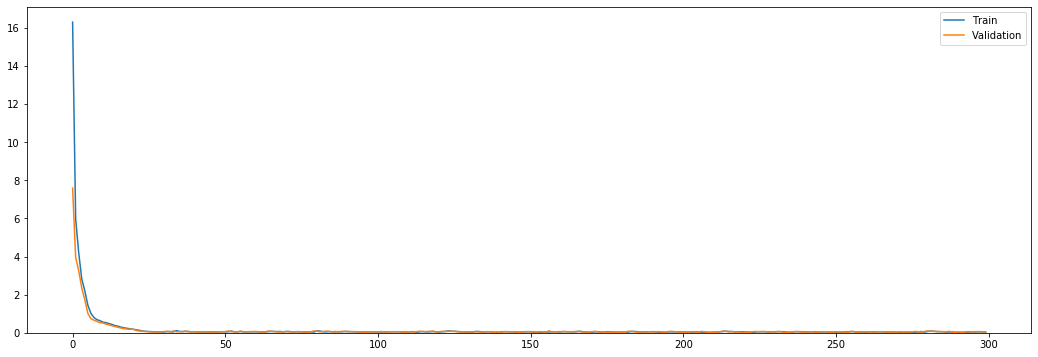

In [34]:
plot_loss(history)

In [35]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.1102041 , 0.4409123 , 0.58086896, 0.62347496, 0.71916   ,
        0.8148451 , 0.8574507 , 0.99740773, 1.3281159 ],
       [0.52453816, 0.89202887, 1.1955315 , 1.2879245 , 1.4954222 ,
        1.70292   , 1.7953122 , 2.0988157 , 2.4663062 ]], dtype=float32)

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [36]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()

## Dataset 2

In [37]:
train_df = pd.read_csv("custom_layer/features2.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets2.csv", index_col=0, header=None, names=['target'])
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [38]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [39]:
target_df.head()

,target
2011-01-29,0.751272
2011-01-30,1.175314
2011-01-31,1.527411
2011-02-01,0.952662
2011-02-02,0.595021


In [40]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [41]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_mo = {'q'+str(i): y_train for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val for i in range(len(quantiles))}

In [42]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

### With dense layers

In [43]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [44]:
model = get_model(inp_shape=(X_train.shape[1],), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [45]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 1575 samples, validate on 394 samples
Epoch 1/300
1575/1575 [==============================] - 3s 2ms/sample - loss: 3.8581 - q0_loss: 0.0070 - q1_loss: 0.0635 - q2_loss: 0.2325 - q3_loss: 0.2250 - q4_loss: 0.3017 - q5_loss: 0.3776 - q6_loss: 0.3175 - q7_loss: 1.0583 - q8_loss: 1.2660 - val_loss: 3.3732 - val_q0_loss: 0.0068 - val_q1_loss: 0.0523 - val_q2_loss: 0.2189 - val_q3_loss: 0.1026 - val_q4_loss: 0.1955 - val_q5_loss: 0.2067 - val_q6_loss: 0.1421 - val_q7_loss: 1.1337 - val_q8_loss: 1.2934
Epoch 2/300
1575/1575 [==============================] - 0s 131us/sample - loss: 3.0756 - q0_loss: 0.0064 - q1_loss: 0.0531 - q2_loss: 0.2162 - q3_loss: 0.0866 - q4_loss: 0.1818 - q5_loss: 0.1778 - q6_loss: 0.0963 - q7_loss: 1.0303 - q8_loss: 1.2229 - val_loss: 2.9695 - val_q0_loss: 0.0069 - val_q1_loss: 0.0564 - val_q2_loss: 0.2160 - val_q3_loss: 0.0685 - val_q4_loss: 0.1195 - val_q5_loss: 0.1068 - val_q6_loss: 0.0704 - val_q7_loss: 1.0556 - val_q8_loss: 1.2505
Epoch 3/300
1575/1575

1575/1575 [==============================] - 0s 138us/sample - loss: 0.3310 - q0_loss: 0.0028 - q1_loss: 0.0216 - q2_loss: 0.0531 - q3_loss: 0.0545 - q4_loss: 0.0751 - q5_loss: 0.0616 - q6_loss: 0.0435 - q7_loss: 0.0137 - q8_loss: 0.0050 - val_loss: 0.3420 - val_q0_loss: 0.0027 - val_q1_loss: 0.0204 - val_q2_loss: 0.0541 - val_q3_loss: 0.0522 - val_q4_loss: 0.0759 - val_q5_loss: 0.0657 - val_q6_loss: 0.0460 - val_q7_loss: 0.0152 - val_q8_loss: 0.0060
Epoch 19/300
1575/1575 [==============================] - 0s 134us/sample - loss: 0.3280 - q0_loss: 0.0027 - q1_loss: 0.0170 - q2_loss: 0.0520 - q3_loss: 0.0541 - q4_loss: 0.0752 - q5_loss: 0.0620 - q6_loss: 0.0441 - q7_loss: 0.0141 - q8_loss: 0.0049 - val_loss: 0.3215 - val_q0_loss: 0.0026 - val_q1_loss: 0.0153 - val_q2_loss: 0.0524 - val_q3_loss: 0.0535 - val_q4_loss: 0.0668 - val_q5_loss: 0.0576 - val_q6_loss: 0.0483 - val_q7_loss: 0.0142 - val_q8_loss: 0.0057
Epoch 20/300
1575/1575 [==============================] - 0s 137us/sample - l

Epoch 36/300
1575/1575 [==============================] - 0s 126us/sample - loss: 0.3007 - q0_loss: 0.0027 - q1_loss: 0.0133 - q2_loss: 0.0440 - q3_loss: 0.0548 - q4_loss: 0.0693 - q5_loss: 0.0563 - q6_loss: 0.0436 - q7_loss: 0.0129 - q8_loss: 0.0032 - val_loss: 0.3316 - val_q0_loss: 0.0024 - val_q1_loss: 0.0136 - val_q2_loss: 0.0474 - val_q3_loss: 0.0533 - val_q4_loss: 0.0786 - val_q5_loss: 0.0660 - val_q6_loss: 0.0479 - val_q7_loss: 0.0146 - val_q8_loss: 0.0040
Epoch 37/300
1575/1575 [==============================] - 0s 119us/sample - loss: 0.3098 - q0_loss: 0.0027 - q1_loss: 0.0132 - q2_loss: 0.0447 - q3_loss: 0.0540 - q4_loss: 0.0732 - q5_loss: 0.0604 - q6_loss: 0.0432 - q7_loss: 0.0130 - q8_loss: 0.0033 - val_loss: 0.3092 - val_q0_loss: 0.0025 - val_q1_loss: 0.0134 - val_q2_loss: 0.0452 - val_q3_loss: 0.0519 - val_q4_loss: 0.0695 - val_q5_loss: 0.0599 - val_q6_loss: 0.0454 - val_q7_loss: 0.0142 - val_q8_loss: 0.0040
Epoch 38/300
1575/1575 [==============================] - 0s 125

1575/1575 [==============================] - 0s 128us/sample - loss: 0.3116 - q0_loss: 0.0024 - q1_loss: 0.0123 - q2_loss: 0.0433 - q3_loss: 0.0548 - q4_loss: 0.0757 - q5_loss: 0.0620 - q6_loss: 0.0443 - q7_loss: 0.0123 - q8_loss: 0.0032 - val_loss: 0.2992 - val_q0_loss: 0.0024 - val_q1_loss: 0.0125 - val_q2_loss: 0.0413 - val_q3_loss: 0.0543 - val_q4_loss: 0.0665 - val_q5_loss: 0.0552 - val_q6_loss: 0.0472 - val_q7_loss: 0.0121 - val_q8_loss: 0.0036
Epoch 54/300
1575/1575 [==============================] - 0s 136us/sample - loss: 0.2943 - q0_loss: 0.0024 - q1_loss: 0.0122 - q2_loss: 0.0420 - q3_loss: 0.0537 - q4_loss: 0.0699 - q5_loss: 0.0563 - q6_loss: 0.0428 - q7_loss: 0.0120 - q8_loss: 0.0031 - val_loss: 0.2919 - val_q0_loss: 0.0023 - val_q1_loss: 0.0124 - val_q2_loss: 0.0404 - val_q3_loss: 0.0511 - val_q4_loss: 0.0658 - val_q5_loss: 0.0549 - val_q6_loss: 0.0439 - val_q7_loss: 0.0131 - val_q8_loss: 0.0038
Epoch 55/300
1575/1575 [==============================] - 0s 117us/sample - l

Epoch 71/300
1575/1575 [==============================] - 0s 122us/sample - loss: 0.2876 - q0_loss: 0.0024 - q1_loss: 0.0111 - q2_loss: 0.0412 - q3_loss: 0.0533 - q4_loss: 0.0680 - q5_loss: 0.0549 - q6_loss: 0.0425 - q7_loss: 0.0106 - q8_loss: 0.0029 - val_loss: 0.2926 - val_q0_loss: 0.0022 - val_q1_loss: 0.0113 - val_q2_loss: 0.0407 - val_q3_loss: 0.0520 - val_q4_loss: 0.0657 - val_q5_loss: 0.0560 - val_q6_loss: 0.0458 - val_q7_loss: 0.0115 - val_q8_loss: 0.0036
Epoch 72/300
1575/1575 [==============================] - 0s 121us/sample - loss: 0.2909 - q0_loss: 0.0024 - q1_loss: 0.0110 - q2_loss: 0.0419 - q3_loss: 0.0542 - q4_loss: 0.0689 - q5_loss: 0.0561 - q6_loss: 0.0432 - q7_loss: 0.0109 - q8_loss: 0.0029 - val_loss: 0.2967 - val_q0_loss: 0.0022 - val_q1_loss: 0.0113 - val_q2_loss: 0.0396 - val_q3_loss: 0.0529 - val_q4_loss: 0.0680 - val_q5_loss: 0.0570 - val_q6_loss: 0.0446 - val_q7_loss: 0.0126 - val_q8_loss: 0.0037
Epoch 73/300
1575/1575 [==============================] - 0s 118

1575/1575 [==============================] - 0s 171us/sample - loss: 0.2910 - q0_loss: 0.0023 - q1_loss: 0.0102 - q2_loss: 0.0418 - q3_loss: 0.0534 - q4_loss: 0.0696 - q5_loss: 0.0564 - q6_loss: 0.0426 - q7_loss: 0.0107 - q8_loss: 0.0029 - val_loss: 0.2891 - val_q0_loss: 0.0023 - val_q1_loss: 0.0100 - val_q2_loss: 0.0402 - val_q3_loss: 0.0517 - val_q4_loss: 0.0652 - val_q5_loss: 0.0554 - val_q6_loss: 0.0463 - val_q7_loss: 0.0110 - val_q8_loss: 0.0032
Epoch 89/300
1575/1575 [==============================] - 0s 218us/sample - loss: 0.2835 - q0_loss: 0.0023 - q1_loss: 0.0100 - q2_loss: 0.0412 - q3_loss: 0.0531 - q4_loss: 0.0676 - q5_loss: 0.0536 - q6_loss: 0.0420 - q7_loss: 0.0100 - q8_loss: 0.0027 - val_loss: 0.2947 - val_q0_loss: 0.0022 - val_q1_loss: 0.0100 - val_q2_loss: 0.0410 - val_q3_loss: 0.0518 - val_q4_loss: 0.0686 - val_q5_loss: 0.0579 - val_q6_loss: 0.0449 - val_q7_loss: 0.0110 - val_q8_loss: 0.0035
Epoch 90/300
1575/1575 [==============================] - 0s 195us/sample - l

Epoch 106/300
1575/1575 [==============================] - 0s 128us/sample - loss: 0.2841 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0413 - q3_loss: 0.0532 - q4_loss: 0.0677 - q5_loss: 0.0542 - q6_loss: 0.0419 - q7_loss: 0.0101 - q8_loss: 0.0028 - val_loss: 0.2875 - val_q0_loss: 0.0022 - val_q1_loss: 0.0092 - val_q2_loss: 0.0402 - val_q3_loss: 0.0522 - val_q4_loss: 0.0660 - val_q5_loss: 0.0548 - val_q6_loss: 0.0445 - val_q7_loss: 0.0112 - val_q8_loss: 0.0033
Epoch 107/300
1575/1575 [==============================] - 0s 130us/sample - loss: 0.2867 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0415 - q3_loss: 0.0533 - q4_loss: 0.0689 - q5_loss: 0.0560 - q6_loss: 0.0427 - q7_loss: 0.0102 - q8_loss: 0.0027 - val_loss: 0.2944 - val_q0_loss: 0.0021 - val_q1_loss: 0.0092 - val_q2_loss: 0.0407 - val_q3_loss: 0.0519 - val_q4_loss: 0.0691 - val_q5_loss: 0.0590 - val_q6_loss: 0.0444 - val_q7_loss: 0.0108 - val_q8_loss: 0.0033
Epoch 108/300
1575/1575 [==============================] - 0s 

1575/1575 [==============================] - 0s 119us/sample - loss: 0.2849 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0416 - q3_loss: 0.0537 - q4_loss: 0.0683 - q5_loss: 0.0545 - q6_loss: 0.0424 - q7_loss: 0.0102 - q8_loss: 0.0027 - val_loss: 0.2901 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0399 - val_q3_loss: 0.0518 - val_q4_loss: 0.0680 - val_q5_loss: 0.0571 - val_q6_loss: 0.0443 - val_q7_loss: 0.0110 - val_q8_loss: 0.0033
Epoch 124/300
1575/1575 [==============================] - 0s 119us/sample - loss: 0.2876 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0421 - q3_loss: 0.0540 - q4_loss: 0.0691 - q5_loss: 0.0557 - q6_loss: 0.0425 - q7_loss: 0.0104 - q8_loss: 0.0026 - val_loss: 0.3092 - val_q0_loss: 0.0023 - val_q1_loss: 0.0094 - val_q2_loss: 0.0424 - val_q3_loss: 0.0546 - val_q4_loss: 0.0729 - val_q5_loss: 0.0601 - val_q6_loss: 0.0479 - val_q7_loss: 0.0132 - val_q8_loss: 0.0031
Epoch 125/300
1575/1575 [==============================] - 0s 124us/sample -

1575/1575 [==============================] - 0s 165us/sample - loss: 0.2936 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0422 - q3_loss: 0.0548 - q4_loss: 0.0705 - q5_loss: 0.0573 - q6_loss: 0.0438 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.2852 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0407 - val_q3_loss: 0.0520 - val_q4_loss: 0.0650 - val_q5_loss: 0.0545 - val_q6_loss: 0.0439 - val_q7_loss: 0.0112 - val_q8_loss: 0.0029
Epoch 141/300
1575/1575 [==============================] - 0s 186us/sample - loss: 0.2840 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0414 - q3_loss: 0.0536 - q4_loss: 0.0682 - q5_loss: 0.0549 - q6_loss: 0.0421 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2873 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0397 - val_q3_loss: 0.0526 - val_q4_loss: 0.0676 - val_q5_loss: 0.0544 - val_q6_loss: 0.0443 - val_q7_loss: 0.0111 - val_q8_loss: 0.0029
Epoch 142/300
1575/1575 [==============================] - 0s 158us/sample -

1575/1575 [==============================] - 0s 237us/sample - loss: 0.2848 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0533 - q4_loss: 0.0686 - q5_loss: 0.0542 - q6_loss: 0.0421 - q7_loss: 0.0102 - q8_loss: 0.0025 - val_loss: 0.2868 - val_q0_loss: 0.0024 - val_q1_loss: 0.0091 - val_q2_loss: 0.0407 - val_q3_loss: 0.0526 - val_q4_loss: 0.0651 - val_q5_loss: 0.0550 - val_q6_loss: 0.0443 - val_q7_loss: 0.0111 - val_q8_loss: 0.0031
Epoch 158/300
1575/1575 [==============================] - 0s 228us/sample - loss: 0.2829 - q0_loss: 0.0023 - q1_loss: 0.0092 - q2_loss: 0.0411 - q3_loss: 0.0531 - q4_loss: 0.0675 - q5_loss: 0.0542 - q6_loss: 0.0420 - q7_loss: 0.0099 - q8_loss: 0.0025 - val_loss: 0.2876 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0397 - val_q3_loss: 0.0513 - val_q4_loss: 0.0679 - val_q5_loss: 0.0565 - val_q6_loss: 0.0442 - val_q7_loss: 0.0108 - val_q8_loss: 0.0029
Epoch 159/300
1575/1575 [==============================] - 1s 355us/sample -

1575/1575 [==============================] - 0s 180us/sample - loss: 0.2871 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0418 - q3_loss: 0.0540 - q4_loss: 0.0692 - q5_loss: 0.0549 - q6_loss: 0.0423 - q7_loss: 0.0104 - q8_loss: 0.0026 - val_loss: 0.2870 - val_q0_loss: 0.0023 - val_q1_loss: 0.0089 - val_q2_loss: 0.0406 - val_q3_loss: 0.0516 - val_q4_loss: 0.0662 - val_q5_loss: 0.0556 - val_q6_loss: 0.0447 - val_q7_loss: 0.0110 - val_q8_loss: 0.0026
Epoch 175/300
1575/1575 [==============================] - 0s 173us/sample - loss: 0.2824 - q0_loss: 0.0023 - q1_loss: 0.0092 - q2_loss: 0.0410 - q3_loss: 0.0528 - q4_loss: 0.0679 - q5_loss: 0.0536 - q6_loss: 0.0416 - q7_loss: 0.0102 - q8_loss: 0.0026 - val_loss: 0.3047 - val_q0_loss: 0.0022 - val_q1_loss: 0.0094 - val_q2_loss: 0.0425 - val_q3_loss: 0.0538 - val_q4_loss: 0.0709 - val_q5_loss: 0.0593 - val_q6_loss: 0.0467 - val_q7_loss: 0.0125 - val_q8_loss: 0.0031
Epoch 176/300
1575/1575 [==============================] - 0s 182us/sample -

1575/1575 [==============================] - 0s 156us/sample - loss: 0.2855 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0416 - q3_loss: 0.0540 - q4_loss: 0.0684 - q5_loss: 0.0548 - q6_loss: 0.0430 - q7_loss: 0.0105 - q8_loss: 0.0026 - val_loss: 0.2881 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0407 - val_q3_loss: 0.0525 - val_q4_loss: 0.0669 - val_q5_loss: 0.0551 - val_q6_loss: 0.0438 - val_q7_loss: 0.0108 - val_q8_loss: 0.0027
Epoch 192/300
1575/1575 [==============================] - 0s 184us/sample - loss: 0.2826 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0413 - q3_loss: 0.0533 - q4_loss: 0.0683 - q5_loss: 0.0545 - q6_loss: 0.0425 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2858 - val_q0_loss: 0.0023 - val_q1_loss: 0.0089 - val_q2_loss: 0.0401 - val_q3_loss: 0.0516 - val_q4_loss: 0.0654 - val_q5_loss: 0.0553 - val_q6_loss: 0.0450 - val_q7_loss: 0.0112 - val_q8_loss: 0.0026
Epoch 193/300
1575/1575 [==============================] - 0s 157us/sample -

1575/1575 [==============================] - 0s 112us/sample - loss: 0.2810 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0533 - q4_loss: 0.0669 - q5_loss: 0.0532 - q6_loss: 0.0416 - q7_loss: 0.0098 - q8_loss: 0.0024 - val_loss: 0.2885 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0402 - val_q3_loss: 0.0516 - val_q4_loss: 0.0665 - val_q5_loss: 0.0565 - val_q6_loss: 0.0458 - val_q7_loss: 0.0109 - val_q8_loss: 0.0025
Epoch 209/300
1575/1575 [==============================] - 0s 116us/sample - loss: 0.2819 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0411 - q3_loss: 0.0531 - q4_loss: 0.0675 - q5_loss: 0.0538 - q6_loss: 0.0420 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2842 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0400 - val_q3_loss: 0.0519 - val_q4_loss: 0.0651 - val_q5_loss: 0.0550 - val_q6_loss: 0.0432 - val_q7_loss: 0.0111 - val_q8_loss: 0.0029
Epoch 210/300
1575/1575 [==============================] - 0s 132us/sample -

1575/1575 [==============================] - 0s 127us/sample - loss: 0.2814 - q0_loss: 0.0024 - q1_loss: 0.0093 - q2_loss: 0.0415 - q3_loss: 0.0541 - q4_loss: 0.0686 - q5_loss: 0.0538 - q6_loss: 0.0423 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2847 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0394 - val_q3_loss: 0.0511 - val_q4_loss: 0.0659 - val_q5_loss: 0.0556 - val_q6_loss: 0.0443 - val_q7_loss: 0.0108 - val_q8_loss: 0.0025
Epoch 226/300
1575/1575 [==============================] - 0s 124us/sample - loss: 0.2808 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0408 - q3_loss: 0.0526 - q4_loss: 0.0667 - q5_loss: 0.0533 - q6_loss: 0.0418 - q7_loss: 0.0100 - q8_loss: 0.0024 - val_loss: 0.2864 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0404 - val_q3_loss: 0.0519 - val_q4_loss: 0.0663 - val_q5_loss: 0.0549 - val_q6_loss: 0.0439 - val_q7_loss: 0.0108 - val_q8_loss: 0.0026
Epoch 227/300
1575/1575 [==============================] - 0s 121us/sample -

1575/1575 [==============================] - 0s 124us/sample - loss: 0.2819 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0413 - q3_loss: 0.0531 - q4_loss: 0.0667 - q5_loss: 0.0533 - q6_loss: 0.0417 - q7_loss: 0.0100 - q8_loss: 0.0026 - val_loss: 0.2838 - val_q0_loss: 0.0021 - val_q1_loss: 0.0089 - val_q2_loss: 0.0399 - val_q3_loss: 0.0514 - val_q4_loss: 0.0665 - val_q5_loss: 0.0542 - val_q6_loss: 0.0437 - val_q7_loss: 0.0106 - val_q8_loss: 0.0026
Epoch 243/300
1575/1575 [==============================] - 0s 125us/sample - loss: 0.2818 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0408 - q3_loss: 0.0527 - q4_loss: 0.0675 - q5_loss: 0.0540 - q6_loss: 0.0419 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2914 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0411 - val_q3_loss: 0.0523 - val_q4_loss: 0.0664 - val_q5_loss: 0.0571 - val_q6_loss: 0.0458 - val_q7_loss: 0.0114 - val_q8_loss: 0.0027
Epoch 244/300
1575/1575 [==============================] - 0s 123us/sample -

1575/1575 [==============================] - 0s 168us/sample - loss: 0.2839 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0416 - q3_loss: 0.0538 - q4_loss: 0.0686 - q5_loss: 0.0550 - q6_loss: 0.0431 - q7_loss: 0.0102 - q8_loss: 0.0025 - val_loss: 0.2894 - val_q0_loss: 0.0022 - val_q1_loss: 0.0091 - val_q2_loss: 0.0414 - val_q3_loss: 0.0527 - val_q4_loss: 0.0670 - val_q5_loss: 0.0547 - val_q6_loss: 0.0442 - val_q7_loss: 0.0113 - val_q8_loss: 0.0027
Epoch 260/300
1575/1575 [==============================] - 0s 159us/sample - loss: 0.2815 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0415 - q3_loss: 0.0533 - q4_loss: 0.0676 - q5_loss: 0.0544 - q6_loss: 0.0423 - q7_loss: 0.0102 - q8_loss: 0.0026 - val_loss: 0.2863 - val_q0_loss: 0.0022 - val_q1_loss: 0.0092 - val_q2_loss: 0.0406 - val_q3_loss: 0.0520 - val_q4_loss: 0.0663 - val_q5_loss: 0.0549 - val_q6_loss: 0.0437 - val_q7_loss: 0.0108 - val_q8_loss: 0.0026
Epoch 261/300
1575/1575 [==============================] - 0s 166us/sample -

1575/1575 [==============================] - 0s 131us/sample - loss: 0.2794 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0534 - q4_loss: 0.0669 - q5_loss: 0.0533 - q6_loss: 0.0418 - q7_loss: 0.0098 - q8_loss: 0.0024 - val_loss: 0.2889 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0411 - val_q3_loss: 0.0526 - val_q4_loss: 0.0657 - val_q5_loss: 0.0555 - val_q6_loss: 0.0451 - val_q7_loss: 0.0116 - val_q8_loss: 0.0029
Epoch 277/300
1575/1575 [==============================] - 0s 118us/sample - loss: 0.2797 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0411 - q3_loss: 0.0530 - q4_loss: 0.0664 - q5_loss: 0.0532 - q6_loss: 0.0414 - q7_loss: 0.0098 - q8_loss: 0.0024 - val_loss: 0.2816 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0392 - val_q3_loss: 0.0511 - val_q4_loss: 0.0651 - val_q5_loss: 0.0547 - val_q6_loss: 0.0436 - val_q7_loss: 0.0107 - val_q8_loss: 0.0025
Epoch 278/300
1575/1575 [==============================] - 0s 124us/sample -

1575/1575 [==============================] - 0s 152us/sample - loss: 0.2801 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0412 - q3_loss: 0.0533 - q4_loss: 0.0672 - q5_loss: 0.0529 - q6_loss: 0.0412 - q7_loss: 0.0099 - q8_loss: 0.0024 - val_loss: 0.2840 - val_q0_loss: 0.0021 - val_q1_loss: 0.0089 - val_q2_loss: 0.0398 - val_q3_loss: 0.0516 - val_q4_loss: 0.0664 - val_q5_loss: 0.0544 - val_q6_loss: 0.0438 - val_q7_loss: 0.0108 - val_q8_loss: 0.0026
Epoch 294/300
1575/1575 [==============================] - 0s 119us/sample - loss: 0.2798 - q0_loss: 0.0023 - q1_loss: 0.0092 - q2_loss: 0.0408 - q3_loss: 0.0528 - q4_loss: 0.0668 - q5_loss: 0.0528 - q6_loss: 0.0413 - q7_loss: 0.0100 - q8_loss: 0.0024 - val_loss: 0.2852 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0402 - val_q3_loss: 0.0515 - val_q4_loss: 0.0656 - val_q5_loss: 0.0547 - val_q6_loss: 0.0437 - val_q7_loss: 0.0112 - val_q8_loss: 0.0027
Epoch 295/300
1575/1575 [==============================] - 0s 120us/sample -

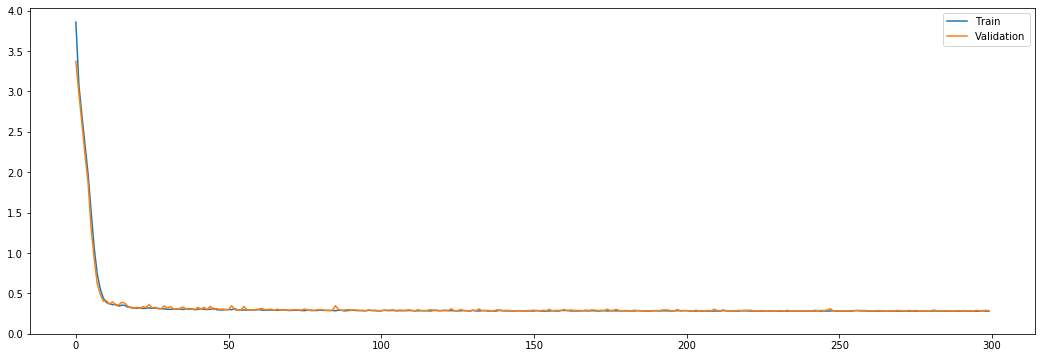

In [46]:
plot_loss(history)

**Predicted distribution**

In [47]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.40922973, 0.5014859 , 0.6093012 , 0.64733964, 0.7373227 ,
        0.82797074, 0.8593173 , 1.0000911 , 1.0730877 ],
       [0.8415297 , 0.9894901 , 1.231245  , 1.292241  , 1.504684  ,
        1.7005391 , 1.7312562 , 1.9820727 , 2.1508193 ]], dtype=float32)

### With distribution layer

In [48]:
model = get_dist_model(inp_shape=(X_train.shape[1],), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [49]:
history_dist = model.fit(X_train, y_train_mo, epochs=300,
                         validation_data=(X_val, y_val_mo))

Train on 1575 samples, validate on 394 samples
Epoch 1/300
1575/1575 [==============================] - 3s 2ms/sample - loss: 1.0662 - q0_loss: 0.0221 - q1_loss: 0.0543 - q2_loss: 0.1461 - q3_loss: 0.1770 - q4_loss: 0.2213 - q5_loss: 0.1941 - q6_loss: 0.1635 - q7_loss: 0.0617 - q8_loss: 0.0156 - val_loss: 0.6698 - val_q0_loss: 0.0072 - val_q1_loss: 0.0217 - val_q2_loss: 0.0981 - val_q3_loss: 0.1279 - val_q4_loss: 0.1596 - val_q5_loss: 0.1262 - val_q6_loss: 0.0970 - val_q7_loss: 0.0210 - val_q8_loss: 0.0055
Epoch 2/300
1575/1575 [==============================] - 0s 119us/sample - loss: 0.5498 - q0_loss: 0.0089 - q1_loss: 0.0232 - q2_loss: 0.0877 - q3_loss: 0.1095 - q4_loss: 0.1307 - q5_loss: 0.0954 - q6_loss: 0.0707 - q7_loss: 0.0164 - q8_loss: 0.0066 - val_loss: 0.4997 - val_q0_loss: 0.0073 - val_q1_loss: 0.0235 - val_q2_loss: 0.0882 - val_q3_loss: 0.1039 - val_q4_loss: 0.1076 - val_q5_loss: 0.0775 - val_q6_loss: 0.0620 - val_q7_loss: 0.0182 - val_q8_loss: 0.0061
Epoch 3/300
1575/1575

1575/1575 [==============================] - 0s 136us/sample - loss: 0.3026 - q0_loss: 0.0037 - q1_loss: 0.0112 - q2_loss: 0.0450 - q3_loss: 0.0568 - q4_loss: 0.0700 - q5_loss: 0.0575 - q6_loss: 0.0458 - q7_loss: 0.0118 - q8_loss: 0.0037 - val_loss: 0.3762 - val_q0_loss: 0.0039 - val_q1_loss: 0.0114 - val_q2_loss: 0.0501 - val_q3_loss: 0.0656 - val_q4_loss: 0.0854 - val_q5_loss: 0.0729 - val_q6_loss: 0.0607 - val_q7_loss: 0.0195 - val_q8_loss: 0.0027
Epoch 19/300
1575/1575 [==============================] - 0s 119us/sample - loss: 0.3395 - q0_loss: 0.0044 - q1_loss: 0.0116 - q2_loss: 0.0477 - q3_loss: 0.0611 - q4_loss: 0.0784 - q5_loss: 0.0663 - q6_loss: 0.0534 - q7_loss: 0.0140 - q8_loss: 0.0046 - val_loss: 0.3596 - val_q0_loss: 0.0049 - val_q1_loss: 0.0143 - val_q2_loss: 0.0585 - val_q3_loss: 0.0734 - val_q4_loss: 0.0836 - val_q5_loss: 0.0604 - val_q6_loss: 0.0468 - val_q7_loss: 0.0114 - val_q8_loss: 0.0038
Epoch 20/300
1575/1575 [==============================] - 0s 135us/sample - l

Epoch 36/300
1575/1575 [==============================] - 0s 160us/sample - loss: 0.3021 - q0_loss: 0.0034 - q1_loss: 0.0101 - q2_loss: 0.0432 - q3_loss: 0.0556 - q4_loss: 0.0712 - q5_loss: 0.0579 - q6_loss: 0.0454 - q7_loss: 0.0112 - q8_loss: 0.0035 - val_loss: 0.2931 - val_q0_loss: 0.0036 - val_q1_loss: 0.0108 - val_q2_loss: 0.0417 - val_q3_loss: 0.0521 - val_q4_loss: 0.0660 - val_q5_loss: 0.0554 - val_q6_loss: 0.0448 - val_q7_loss: 0.0116 - val_q8_loss: 0.0035
Epoch 37/300
1575/1575 [==============================] - 0s 164us/sample - loss: 0.2977 - q0_loss: 0.0037 - q1_loss: 0.0103 - q2_loss: 0.0432 - q3_loss: 0.0546 - q4_loss: 0.0692 - q5_loss: 0.0565 - q6_loss: 0.0450 - q7_loss: 0.0114 - q8_loss: 0.0040 - val_loss: 0.2922 - val_q0_loss: 0.0037 - val_q1_loss: 0.0100 - val_q2_loss: 0.0411 - val_q3_loss: 0.0517 - val_q4_loss: 0.0654 - val_q5_loss: 0.0557 - val_q6_loss: 0.0448 - val_q7_loss: 0.0119 - val_q8_loss: 0.0038
Epoch 38/300
1575/1575 [==============================] - 0s 163

1575/1575 [==============================] - 0s 163us/sample - loss: 0.3051 - q0_loss: 0.0032 - q1_loss: 0.0103 - q2_loss: 0.0446 - q3_loss: 0.0572 - q4_loss: 0.0713 - q5_loss: 0.0572 - q6_loss: 0.0454 - q7_loss: 0.0112 - q8_loss: 0.0033 - val_loss: 0.3103 - val_q0_loss: 0.0034 - val_q1_loss: 0.0095 - val_q2_loss: 0.0396 - val_q3_loss: 0.0530 - val_q4_loss: 0.0722 - val_q5_loss: 0.0616 - val_q6_loss: 0.0495 - val_q7_loss: 0.0132 - val_q8_loss: 0.0040
Epoch 54/300
1575/1575 [==============================] - 0s 159us/sample - loss: 0.2993 - q0_loss: 0.0037 - q1_loss: 0.0104 - q2_loss: 0.0437 - q3_loss: 0.0556 - q4_loss: 0.0696 - q5_loss: 0.0557 - q6_loss: 0.0442 - q7_loss: 0.0116 - q8_loss: 0.0039 - val_loss: 0.3001 - val_q0_loss: 0.0039 - val_q1_loss: 0.0099 - val_q2_loss: 0.0411 - val_q3_loss: 0.0521 - val_q4_loss: 0.0684 - val_q5_loss: 0.0581 - val_q6_loss: 0.0472 - val_q7_loss: 0.0118 - val_q8_loss: 0.0043
Epoch 55/300
1575/1575 [==============================] - 0s 162us/sample - l

1575/1575 [==============================] - 0s 120us/sample - loss: 0.3002 - q0_loss: 0.0035 - q1_loss: 0.0102 - q2_loss: 0.0432 - q3_loss: 0.0553 - q4_loss: 0.0700 - q5_loss: 0.0570 - q6_loss: 0.0453 - q7_loss: 0.0116 - q8_loss: 0.0035 - val_loss: 0.3029 - val_q0_loss: 0.0032 - val_q1_loss: 0.0094 - val_q2_loss: 0.0412 - val_q3_loss: 0.0528 - val_q4_loss: 0.0682 - val_q5_loss: 0.0590 - val_q6_loss: 0.0490 - val_q7_loss: 0.0151 - val_q8_loss: 0.0030
Epoch 71/300
1575/1575 [==============================] - 0s 123us/sample - loss: 0.2943 - q0_loss: 0.0035 - q1_loss: 0.0097 - q2_loss: 0.0422 - q3_loss: 0.0543 - q4_loss: 0.0687 - q5_loss: 0.0560 - q6_loss: 0.0450 - q7_loss: 0.0113 - q8_loss: 0.0037 - val_loss: 0.2872 - val_q0_loss: 0.0034 - val_q1_loss: 0.0090 - val_q2_loss: 0.0401 - val_q3_loss: 0.0515 - val_q4_loss: 0.0662 - val_q5_loss: 0.0555 - val_q6_loss: 0.0449 - val_q7_loss: 0.0112 - val_q8_loss: 0.0034
Epoch 72/300
1575/1575 [==============================] - 0s 124us/sample - l

Epoch 88/300
1575/1575 [==============================] - 0s 124us/sample - loss: 0.2920 - q0_loss: 0.0030 - q1_loss: 0.0099 - q2_loss: 0.0423 - q3_loss: 0.0544 - q4_loss: 0.0683 - q5_loss: 0.0553 - q6_loss: 0.0437 - q7_loss: 0.0109 - q8_loss: 0.0033 - val_loss: 0.2965 - val_q0_loss: 0.0028 - val_q1_loss: 0.0099 - val_q2_loss: 0.0407 - val_q3_loss: 0.0521 - val_q4_loss: 0.0668 - val_q5_loss: 0.0570 - val_q6_loss: 0.0468 - val_q7_loss: 0.0144 - val_q8_loss: 0.0031
Epoch 89/300
1575/1575 [==============================] - 0s 123us/sample - loss: 0.2945 - q0_loss: 0.0031 - q1_loss: 0.0101 - q2_loss: 0.0434 - q3_loss: 0.0555 - q4_loss: 0.0692 - q5_loss: 0.0549 - q6_loss: 0.0431 - q7_loss: 0.0104 - q8_loss: 0.0031 - val_loss: 0.2891 - val_q0_loss: 0.0025 - val_q1_loss: 0.0095 - val_q2_loss: 0.0402 - val_q3_loss: 0.0523 - val_q4_loss: 0.0663 - val_q5_loss: 0.0546 - val_q6_loss: 0.0442 - val_q7_loss: 0.0121 - val_q8_loss: 0.0034
Epoch 90/300
1575/1575 [==============================] - 0s 131

1575/1575 [==============================] - 0s 121us/sample - loss: 0.2910 - q0_loss: 0.0028 - q1_loss: 0.0098 - q2_loss: 0.0426 - q3_loss: 0.0550 - q4_loss: 0.0691 - q5_loss: 0.0553 - q6_loss: 0.0435 - q7_loss: 0.0108 - q8_loss: 0.0029 - val_loss: 0.2948 - val_q0_loss: 0.0032 - val_q1_loss: 0.0097 - val_q2_loss: 0.0403 - val_q3_loss: 0.0513 - val_q4_loss: 0.0676 - val_q5_loss: 0.0587 - val_q6_loss: 0.0472 - val_q7_loss: 0.0111 - val_q8_loss: 0.0034
Epoch 106/300
1575/1575 [==============================] - 0s 119us/sample - loss: 0.3044 - q0_loss: 0.0037 - q1_loss: 0.0102 - q2_loss: 0.0435 - q3_loss: 0.0553 - q4_loss: 0.0705 - q5_loss: 0.0579 - q6_loss: 0.0459 - q7_loss: 0.0122 - q8_loss: 0.0040 - val_loss: 0.2955 - val_q0_loss: 0.0040 - val_q1_loss: 0.0102 - val_q2_loss: 0.0410 - val_q3_loss: 0.0523 - val_q4_loss: 0.0668 - val_q5_loss: 0.0565 - val_q6_loss: 0.0451 - val_q7_loss: 0.0111 - val_q8_loss: 0.0040
Epoch 107/300
1575/1575 [==============================] - 0s 128us/sample -

1575/1575 [==============================] - 0s 118us/sample - loss: 0.2886 - q0_loss: 0.0033 - q1_loss: 0.0101 - q2_loss: 0.0418 - q3_loss: 0.0535 - q4_loss: 0.0675 - q5_loss: 0.0542 - q6_loss: 0.0427 - q7_loss: 0.0103 - q8_loss: 0.0032 - val_loss: 0.3103 - val_q0_loss: 0.0039 - val_q1_loss: 0.0097 - val_q2_loss: 0.0429 - val_q3_loss: 0.0551 - val_q4_loss: 0.0705 - val_q5_loss: 0.0586 - val_q6_loss: 0.0469 - val_q7_loss: 0.0133 - val_q8_loss: 0.0039
Epoch 123/300
1575/1575 [==============================] - 0s 117us/sample - loss: 0.2903 - q0_loss: 0.0031 - q1_loss: 0.0096 - q2_loss: 0.0421 - q3_loss: 0.0545 - q4_loss: 0.0689 - q5_loss: 0.0553 - q6_loss: 0.0433 - q7_loss: 0.0103 - q8_loss: 0.0033 - val_loss: 0.2928 - val_q0_loss: 0.0032 - val_q1_loss: 0.0096 - val_q2_loss: 0.0416 - val_q3_loss: 0.0527 - val_q4_loss: 0.0668 - val_q5_loss: 0.0566 - val_q6_loss: 0.0457 - val_q7_loss: 0.0111 - val_q8_loss: 0.0032
Epoch 124/300
1575/1575 [==============================] - 0s 123us/sample -

1575/1575 [==============================] - 0s 112us/sample - loss: 0.2843 - q0_loss: 0.0028 - q1_loss: 0.0097 - q2_loss: 0.0415 - q3_loss: 0.0532 - q4_loss: 0.0665 - q5_loss: 0.0531 - q6_loss: 0.0420 - q7_loss: 0.0104 - q8_loss: 0.0029 - val_loss: 0.3061 - val_q0_loss: 0.0029 - val_q1_loss: 0.0101 - val_q2_loss: 0.0436 - val_q3_loss: 0.0559 - val_q4_loss: 0.0699 - val_q5_loss: 0.0569 - val_q6_loss: 0.0463 - val_q7_loss: 0.0127 - val_q8_loss: 0.0027
Epoch 140/300
1575/1575 [==============================] - 0s 110us/sample - loss: 0.2851 - q0_loss: 0.0027 - q1_loss: 0.0097 - q2_loss: 0.0419 - q3_loss: 0.0538 - q4_loss: 0.0674 - q5_loss: 0.0537 - q6_loss: 0.0424 - q7_loss: 0.0105 - q8_loss: 0.0027 - val_loss: 0.2886 - val_q0_loss: 0.0025 - val_q1_loss: 0.0095 - val_q2_loss: 0.0400 - val_q3_loss: 0.0512 - val_q4_loss: 0.0669 - val_q5_loss: 0.0563 - val_q6_loss: 0.0449 - val_q7_loss: 0.0111 - val_q8_loss: 0.0026
Epoch 141/300
1575/1575 [==============================] - 0s 119us/sample -

1575/1575 [==============================] - 0s 145us/sample - loss: 0.2888 - q0_loss: 0.0027 - q1_loss: 0.0096 - q2_loss: 0.0420 - q3_loss: 0.0538 - q4_loss: 0.0683 - q5_loss: 0.0551 - q6_loss: 0.0435 - q7_loss: 0.0107 - q8_loss: 0.0029 - val_loss: 0.2927 - val_q0_loss: 0.0023 - val_q1_loss: 0.0088 - val_q2_loss: 0.0397 - val_q3_loss: 0.0514 - val_q4_loss: 0.0665 - val_q5_loss: 0.0560 - val_q6_loss: 0.0449 - val_q7_loss: 0.0134 - val_q8_loss: 0.0041
Epoch 157/300
1575/1575 [==============================] - 0s 145us/sample - loss: 0.2907 - q0_loss: 0.0028 - q1_loss: 0.0100 - q2_loss: 0.0418 - q3_loss: 0.0536 - q4_loss: 0.0680 - q5_loss: 0.0552 - q6_loss: 0.0438 - q7_loss: 0.0110 - q8_loss: 0.0031 - val_loss: 0.2887 - val_q0_loss: 0.0027 - val_q1_loss: 0.0094 - val_q2_loss: 0.0402 - val_q3_loss: 0.0516 - val_q4_loss: 0.0658 - val_q5_loss: 0.0559 - val_q6_loss: 0.0449 - val_q7_loss: 0.0120 - val_q8_loss: 0.0028
Epoch 158/300
1575/1575 [==============================] - 0s 147us/sample -

1575/1575 [==============================] - 0s 124us/sample - loss: 0.2835 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0413 - q3_loss: 0.0532 - q4_loss: 0.0669 - q5_loss: 0.0535 - q6_loss: 0.0421 - q7_loss: 0.0102 - q8_loss: 0.0027 - val_loss: 0.2876 - val_q0_loss: 0.0026 - val_q1_loss: 0.0094 - val_q2_loss: 0.0398 - val_q3_loss: 0.0512 - val_q4_loss: 0.0658 - val_q5_loss: 0.0559 - val_q6_loss: 0.0452 - val_q7_loss: 0.0114 - val_q8_loss: 0.0025
Epoch 174/300
1575/1575 [==============================] - 0s 117us/sample - loss: 0.2826 - q0_loss: 0.0025 - q1_loss: 0.0095 - q2_loss: 0.0417 - q3_loss: 0.0538 - q4_loss: 0.0677 - q5_loss: 0.0538 - q6_loss: 0.0422 - q7_loss: 0.0104 - q8_loss: 0.0027 - val_loss: 0.2914 - val_q0_loss: 0.0025 - val_q1_loss: 0.0098 - val_q2_loss: 0.0412 - val_q3_loss: 0.0530 - val_q4_loss: 0.0670 - val_q5_loss: 0.0545 - val_q6_loss: 0.0433 - val_q7_loss: 0.0119 - val_q8_loss: 0.0030
Epoch 175/300
1575/1575 [==============================] - 0s 112us/sample -

1575/1575 [==============================] - 0s 142us/sample - loss: 0.2813 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0413 - q3_loss: 0.0529 - q4_loss: 0.0666 - q5_loss: 0.0533 - q6_loss: 0.0420 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.2866 - val_q0_loss: 0.0025 - val_q1_loss: 0.0094 - val_q2_loss: 0.0395 - val_q3_loss: 0.0512 - val_q4_loss: 0.0659 - val_q5_loss: 0.0556 - val_q6_loss: 0.0445 - val_q7_loss: 0.0114 - val_q8_loss: 0.0025
Epoch 191/300
1575/1575 [==============================] - 0s 157us/sample - loss: 0.2838 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0414 - q3_loss: 0.0536 - q4_loss: 0.0676 - q5_loss: 0.0540 - q6_loss: 0.0426 - q7_loss: 0.0104 - q8_loss: 0.0027 - val_loss: 0.2925 - val_q0_loss: 0.0027 - val_q1_loss: 0.0106 - val_q2_loss: 0.0421 - val_q3_loss: 0.0535 - val_q4_loss: 0.0668 - val_q5_loss: 0.0549 - val_q6_loss: 0.0438 - val_q7_loss: 0.0108 - val_q8_loss: 0.0028
Epoch 192/300
1575/1575 [==============================] - 0s 196us/sample -

1575/1575 [==============================] - 0s 176us/sample - loss: 0.2814 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0414 - q3_loss: 0.0533 - q4_loss: 0.0670 - q5_loss: 0.0534 - q6_loss: 0.0420 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2866 - val_q0_loss: 0.0024 - val_q1_loss: 0.0091 - val_q2_loss: 0.0397 - val_q3_loss: 0.0510 - val_q4_loss: 0.0653 - val_q5_loss: 0.0555 - val_q6_loss: 0.0447 - val_q7_loss: 0.0118 - val_q8_loss: 0.0030
Epoch 208/300
1575/1575 [==============================] - 0s 177us/sample - loss: 0.2817 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0414 - q3_loss: 0.0530 - q4_loss: 0.0665 - q5_loss: 0.0530 - q6_loss: 0.0420 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.2911 - val_q0_loss: 0.0026 - val_q1_loss: 0.0096 - val_q2_loss: 0.0408 - val_q3_loss: 0.0524 - val_q4_loss: 0.0666 - val_q5_loss: 0.0555 - val_q6_loss: 0.0448 - val_q7_loss: 0.0117 - val_q8_loss: 0.0028
Epoch 209/300
1575/1575 [==============================] - 0s 196us/sample -

1575/1575 [==============================] - 0s 155us/sample - loss: 0.2812 - q0_loss: 0.0025 - q1_loss: 0.0095 - q2_loss: 0.0416 - q3_loss: 0.0533 - q4_loss: 0.0669 - q5_loss: 0.0527 - q6_loss: 0.0414 - q7_loss: 0.0104 - q8_loss: 0.0025 - val_loss: 0.2912 - val_q0_loss: 0.0028 - val_q1_loss: 0.0100 - val_q2_loss: 0.0416 - val_q3_loss: 0.0529 - val_q4_loss: 0.0664 - val_q5_loss: 0.0551 - val_q6_loss: 0.0439 - val_q7_loss: 0.0113 - val_q8_loss: 0.0028
Epoch 225/300
1575/1575 [==============================] - 0s 156us/sample - loss: 0.2827 - q0_loss: 0.0025 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0534 - q4_loss: 0.0679 - q5_loss: 0.0542 - q6_loss: 0.0425 - q7_loss: 0.0101 - q8_loss: 0.0026 - val_loss: 0.2857 - val_q0_loss: 0.0023 - val_q1_loss: 0.0092 - val_q2_loss: 0.0396 - val_q3_loss: 0.0512 - val_q4_loss: 0.0668 - val_q5_loss: 0.0554 - val_q6_loss: 0.0440 - val_q7_loss: 0.0110 - val_q8_loss: 0.0026
Epoch 226/300
1575/1575 [==============================] - 0s 154us/sample -

1575/1575 [==============================] - 0s 148us/sample - loss: 0.2817 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0417 - q3_loss: 0.0537 - q4_loss: 0.0668 - q5_loss: 0.0534 - q6_loss: 0.0419 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2953 - val_q0_loss: 0.0023 - val_q1_loss: 0.0092 - val_q2_loss: 0.0403 - val_q3_loss: 0.0521 - val_q4_loss: 0.0695 - val_q5_loss: 0.0590 - val_q6_loss: 0.0465 - val_q7_loss: 0.0108 - val_q8_loss: 0.0027
Epoch 242/300
1575/1575 [==============================] - 0s 137us/sample - loss: 0.2848 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0415 - q3_loss: 0.0534 - q4_loss: 0.0671 - q5_loss: 0.0538 - q6_loss: 0.0421 - q7_loss: 0.0107 - q8_loss: 0.0028 - val_loss: 0.2894 - val_q0_loss: 0.0025 - val_q1_loss: 0.0094 - val_q2_loss: 0.0404 - val_q3_loss: 0.0519 - val_q4_loss: 0.0667 - val_q5_loss: 0.0551 - val_q6_loss: 0.0445 - val_q7_loss: 0.0119 - val_q8_loss: 0.0029
Epoch 243/300
1575/1575 [==============================] - 0s 152us/sample -

1575/1575 [==============================] - 0s 149us/sample - loss: 0.2821 - q0_loss: 0.0025 - q1_loss: 0.0094 - q2_loss: 0.0415 - q3_loss: 0.0540 - q4_loss: 0.0681 - q5_loss: 0.0539 - q6_loss: 0.0425 - q7_loss: 0.0105 - q8_loss: 0.0027 - val_loss: 0.2855 - val_q0_loss: 0.0025 - val_q1_loss: 0.0091 - val_q2_loss: 0.0401 - val_q3_loss: 0.0513 - val_q4_loss: 0.0655 - val_q5_loss: 0.0553 - val_q6_loss: 0.0445 - val_q7_loss: 0.0111 - val_q8_loss: 0.0024
Epoch 259/300
1575/1575 [==============================] - 0s 150us/sample - loss: 0.2833 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0414 - q3_loss: 0.0535 - q4_loss: 0.0678 - q5_loss: 0.0537 - q6_loss: 0.0419 - q7_loss: 0.0100 - q8_loss: 0.0026 - val_loss: 0.2838 - val_q0_loss: 0.0024 - val_q1_loss: 0.0094 - val_q2_loss: 0.0400 - val_q3_loss: 0.0512 - val_q4_loss: 0.0650 - val_q5_loss: 0.0548 - val_q6_loss: 0.0441 - val_q7_loss: 0.0108 - val_q8_loss: 0.0027
Epoch 260/300
1575/1575 [==============================] - 0s 152us/sample -

1575/1575 [==============================] - 0s 262us/sample - loss: 0.2831 - q0_loss: 0.0024 - q1_loss: 0.0097 - q2_loss: 0.0414 - q3_loss: 0.0533 - q4_loss: 0.0676 - q5_loss: 0.0546 - q6_loss: 0.0431 - q7_loss: 0.0106 - q8_loss: 0.0027 - val_loss: 0.2886 - val_q0_loss: 0.0026 - val_q1_loss: 0.0096 - val_q2_loss: 0.0406 - val_q3_loss: 0.0524 - val_q4_loss: 0.0668 - val_q5_loss: 0.0543 - val_q6_loss: 0.0431 - val_q7_loss: 0.0115 - val_q8_loss: 0.0030
Epoch 276/300
1575/1575 [==============================] - 0s 191us/sample - loss: 0.2868 - q0_loss: 0.0025 - q1_loss: 0.0102 - q2_loss: 0.0428 - q3_loss: 0.0546 - q4_loss: 0.0676 - q5_loss: 0.0546 - q6_loss: 0.0432 - q7_loss: 0.0112 - q8_loss: 0.0029 - val_loss: 0.2875 - val_q0_loss: 0.0026 - val_q1_loss: 0.0092 - val_q2_loss: 0.0401 - val_q3_loss: 0.0514 - val_q4_loss: 0.0659 - val_q5_loss: 0.0558 - val_q6_loss: 0.0451 - val_q7_loss: 0.0110 - val_q8_loss: 0.0025
Epoch 277/300
1575/1575 [==============================] - 0s 236us/sample -

1575/1575 [==============================] - 0s 145us/sample - loss: 0.2825 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0414 - q3_loss: 0.0531 - q4_loss: 0.0670 - q5_loss: 0.0537 - q6_loss: 0.0421 - q7_loss: 0.0102 - q8_loss: 0.0026 - val_loss: 0.2837 - val_q0_loss: 0.0024 - val_q1_loss: 0.0091 - val_q2_loss: 0.0395 - val_q3_loss: 0.0510 - val_q4_loss: 0.0651 - val_q5_loss: 0.0549 - val_q6_loss: 0.0441 - val_q7_loss: 0.0111 - val_q8_loss: 0.0026
Epoch 293/300
1575/1575 [==============================] - ETA: 0s - loss: 0.2804 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0415 - q3_loss: 0.0535 - q4_loss: 0.0669 - q5_loss: 0.0526 - q6_loss: 0.0414 - q7_loss: 0.0101 - q8_loss: 0.002 - 0s 151us/sample - loss: 0.2791 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0409 - q3_loss: 0.0526 - q4_loss: 0.0662 - q5_loss: 0.0523 - q6_loss: 0.0410 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2838 - val_q0_loss: 0.0024 - val_q1_loss: 0.0090 - val_q2_loss: 0.0396 - val_q3_loss: 0.0512 

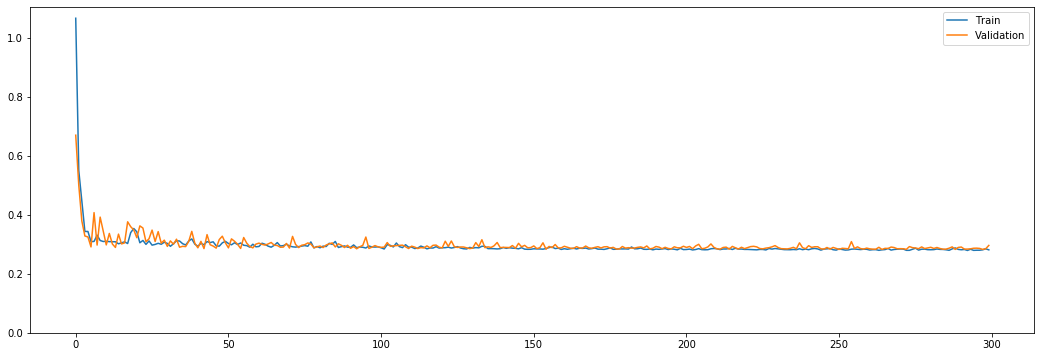

In [50]:
plot_loss(history_dist)

### Compare loss

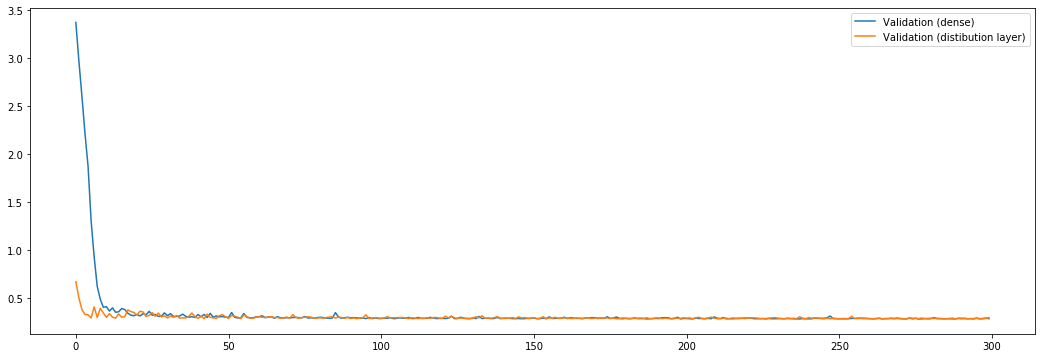

In [51]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 0

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

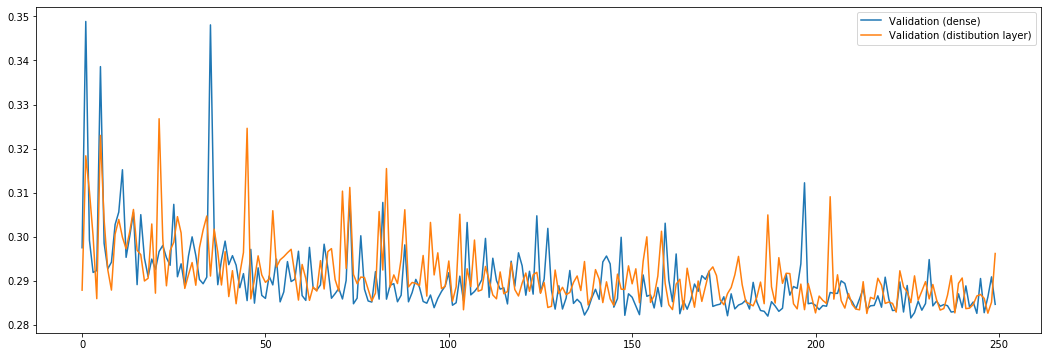

In [52]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 50

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

In [53]:
# "true" quantiles
pd.Series(np.random.normal(0.75, 0.13, size=100000)).quantile(quantiles)

0.005    0.413422
0.025    0.495471
0.165    0.623631
0.250    0.661800
0.500    0.750262
0.750    0.838382
0.835    0.877499
0.975    1.005410
0.995    1.087665
dtype: float64

In [54]:
# "true" quantiles
pd.Series(np.random.normal(1.5, 0.25, size=100000)).quantile(quantiles)

0.005    0.863062
0.025    1.012755
0.165    1.257051
0.250    1.331681
0.500    1.500345
0.750    1.667992
0.835    1.742600
0.975    1.987880
0.995    2.141412
dtype: float64

**Result**: The toy dataset contains two simple distributions, with either $\mu=0.75, \sigma=0.13$ or $\mu=1.5, \sigma=0.25$, depending on whether it is a weekday or weekend. The observed 'demand' are samples distributed as such. For these simple distributions, the Pinball Loss is able to (approximately) retrieve the correct quantiles!